In [65]:
import torch

import numpy as np
import scipy.stats as st
from tqdm.notebook import tqdm, trange

import matplotlib.pyplot as plt

In [199]:
"""
https://github.com/ColCarroll/minimc.git
"""

def leapfrog(q, p, dVdq, potential, path_len, step_size):
    """Leapfrog integrator for Hamiltonian Monte Carlo.
    Parameters
    ----------
    q : np.floatX
        Initial position
    p : np.floatX
        Initial momentum
    dVdq : np.floatX
        Gradient of the potential at the initial coordinates
    potential : callable
        Value and gradient of the potential
    path_len : float
        How long to integrate for
    step_size : float
        How long each integration step should be
    Returns
    -------
    q, p : np.floatX, np.floatX
        New position and momentum
    """
    q, p = np.copy(q), np.copy(p)

    p -= step_size * dVdq / 2  # half step
    for _ in np.arange(path_len):#np.arange(np.round(path_len / step_size) - 1):
        q += step_size * p  # whole step
        V, dVdq = potential(q)
        p -= step_size * dVdq  # whole step
    q += step_size * p  # whole step
    V, dVdq = potential(q)
    p -= step_size * dVdq / 2  # half step

    # momentum flip at end
    return q, -p, V, dVdq

In [200]:
"""
Adapted from:
https://github.com/ColCarroll/minimc.git
"""


def hamiltonian_monte_carlo(
    numiter,
    burnin,
    thinning,
    potential,
    initial_position,
    initial_potential=None,
    initial_potential_grad=None,
    path_len=1,
    initial_step_size=0.1,
    integrator=leapfrog,
    max_energy_change=1000.0,
):
    """Run Hamiltonian Monte Carlo sampling.
    Parameters
    ----------
    n_samples : int
        Number of samples to return
    negative_log_prob : callable
        The negative log probability to sample from
    initial_position : np.array
        A place to start sampling from.
    tune: int
        Number of iterations to run tuning
    path_len : float
        How long each integration path is. Smaller is faster and more correlated.
    initial_step_size : float
        How long each integration step is. This will be tuned automatically.
    max_energy_change : float
        The largest tolerable integration error. Transitions with energy changes
        larger than this will be declared divergences.
    Returns
    -------
    np.array
        Array of length `n_samples`.
    """
    acceptance_count=0
    initial_position = np.array(initial_position)
    if initial_potential is None or initial_potential_grad is None:
        initial_potential, initial_potential_grad = potential(initial_position)

    q_last=initial_position
    # collect all our samples in a list
    samples = []
    accept_rates= []
    
    # Keep a single object for momentum resamplingtqdm
    momentum = st.norm(0, 1)

    step_size = initial_step_size
    
    with trange(numiter) as tr:
        for t in tr:
            p0=momentum.rvs(size=initial_position.shape[:1])
            # Integrate over our path to get a new position and momentum
            q_new, p_new, final_V, final_dVdq = integrator(
                q_last,
                p0,
                initial_potential_grad,
                potential,
                path_len=path_len,#2* np.random.rand()* path_len,  # We jitter the path length a bit
                step_size=step_size,
            )

            start_log_p = np.sum(momentum.logpdf(p0)) - initial_potential
            new_log_p = np.sum(momentum.logpdf(p_new)) - final_V
            energy_change = new_log_p - start_log_p

            # Check Metropolis acceptance criterion
            p_accept = min(1, np.exp(energy_change))
            if np.random.rand() < p_accept:
                acceptance_count+=1
                initial_potential = final_V
                initial_potential_grad = final_dVdq
            else:
                q_new=q_last

            if (t - burnin) % thinning == 0:
                        samples.append(q_new)

            acceptance_rate=acceptance_count/(t+1)
            if t % 50 ==0:
                accept_rates.append(acceptance_rate)
                if acceptance_rate < 0.2:
                    step_size*=0.9
                if acceptance_rate > 0.8:
                    step_size*=1.1

            tr.set_description('HMC')        
            tr.set_postfix(accept_rate=acceptance_rate, step=step_size)

            q_last=q_new
    return samples, accept_rates


In [190]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device ='cpu'

In [156]:
import math
def logmvnpdf(theta, mu, v=1.):
    """
    Evaluation of log proba with density N(0,v*I_n)

    Parameters:
    x (Tensor): Data tensor of size NxD

    Returns:
    logproba (Tensor): size N, vector of log probabilities
    """
    dim = theta.shape[1]
    S = v*torch.ones(dim).type_as(theta).to(device)
    n_x = theta.shape[0]

    H = S.view(dim, 1, 1).inverse().view(1, 1, dim)
    d = ((theta-mu.view(1, dim))**2).view(n_x, dim)
    const = 0.5*S.log().sum()+0.5*dim*torch.tensor(2*math.pi).log()
    return -0.5*(H*d).sum(2).squeeze()-const

def logpdf(x):
    mu0=torch.tensor(-4.)
    mu1=torch.tensor(2.)
    lp=torch.stack([logmvnpdf(x,mu0,1.),logmvnpdf(x,mu1,.5)], dim=0).logsumexp(0)-torch.tensor(2.).log()
    return lp


def potential(x):
    theta=torch.Tensor(x).requires_grad_(True).float()
    #print(x)
    lp=logpdf(theta.unsqueeze(0))
    lp.backward()
    return -lp.detach().numpy(), -theta.grad.numpy()


In [172]:
%matplotlib inline
samples, accept_rates = hamiltonian_monte_carlo(20000,1000,20, potential,
                                  initial_position=np.zeros(1), 
                                  initial_step_size=0.5,
#                                  tune=,
                                 #path_len=100,
                                 )


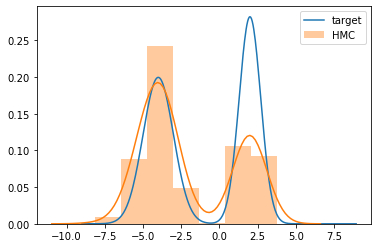

In [173]:
import seaborn as sns                                 
%matplotlib inline
X=torch.arange(-9,9,.05).unsqueeze(1)

Y=logpdf(X).exp()
C=(Y*.05).sum()
fig, ax = plt.subplots()
ax.plot(X,Y/C, label='target')
sns.distplot(samples[0:-1:3], label='HMC')
plt.legend()



# Bayesian inference #

In [174]:
from Experiments.foong import Setup
layerwidth=50
nblayers=1
setup=Setup(device,layerwidth=layerwidth,nblayers=nblayers)

# Target density #

In [175]:
param_count=setup.param_count
logposterior=setup.logposterior

size_sample

200

In [176]:
from Inference.PointEstimate import AdamGradientDescent
def _MAP(nbiter, std_init,logposterior, dim, device='cpu'):
        optimizer = AdamGradientDescent(logposterior, nbiter, .01, .00000001, 50, .5, device, True)

        theta0 = torch.empty((1, dim), device=device).normal_(0., std=std_init)
        best_theta, best_score, score = optimizer.run(theta0)

        return best_theta.detach().clone()

theta=_MAP(20000,1., logposterior, param_count)

Epoch [1/20000], Loss: 50869.16796875, Learning Rate: 0.01
Epoch [2/20000], Loss: 32397.59765625, Learning Rate: 0.01
Epoch [3/20000], Loss: 18841.34765625, Learning Rate: 0.01
Epoch [4/20000], Loss: 9972.7470703125, Learning Rate: 0.01
Epoch [5/20000], Loss: 5227.96533203125, Learning Rate: 0.01
Epoch [6/20000], Loss: 3692.835693359375, Learning Rate: 0.01
Epoch [7/20000], Loss: 4268.6337890625, Learning Rate: 0.01
Epoch [8/20000], Loss: 5905.0927734375, Learning Rate: 0.01
Epoch [9/20000], Loss: 7757.56396484375, Learning Rate: 0.01
Epoch [10/20000], Loss: 9239.658203125, Learning Rate: 0.01
Epoch [11/20000], Loss: 10022.3134765625, Learning Rate: 0.01
Epoch [12/20000], Loss: 10007.947265625, Learning Rate: 0.01
Epoch [13/20000], Loss: 9281.61328125, Learning Rate: 0.01
Epoch [14/20000], Loss: 8045.95556640625, Learning Rate: 0.01
Epoch [15/20000], Loss: 6556.52294921875, Learning Rate: 0.01
Epoch [16/20000], Loss: 5069.76318359375, Learning Rate: 0.01
Epoch [17/20000], Loss: 3805.35

Epoch [132/20000], Loss: 311.0654602050781, Learning Rate: 0.01
Epoch [133/20000], Loss: 307.54010009765625, Learning Rate: 0.01
Epoch [134/20000], Loss: 304.09466552734375, Learning Rate: 0.01
Epoch [135/20000], Loss: 300.7266540527344, Learning Rate: 0.01
Epoch [136/20000], Loss: 297.43060302734375, Learning Rate: 0.01
Epoch [137/20000], Loss: 294.1982116699219, Learning Rate: 0.01
Epoch [138/20000], Loss: 291.0238037109375, Learning Rate: 0.01
Epoch [139/20000], Loss: 287.9034423828125, Learning Rate: 0.01
Epoch [140/20000], Loss: 284.8382568359375, Learning Rate: 0.01
Epoch [141/20000], Loss: 281.8280944824219, Learning Rate: 0.01
Epoch [142/20000], Loss: 278.8743591308594, Learning Rate: 0.01
Epoch [143/20000], Loss: 275.9767761230469, Learning Rate: 0.01
Epoch [144/20000], Loss: 273.13177490234375, Learning Rate: 0.01
Epoch [145/20000], Loss: 270.3376770019531, Learning Rate: 0.01
Epoch [146/20000], Loss: 267.59027099609375, Learning Rate: 0.01
Epoch [147/20000], Loss: 264.888122

Epoch [266/20000], Loss: 127.93229675292969, Learning Rate: 0.01
Epoch [267/20000], Loss: 127.60874938964844, Learning Rate: 0.01
Epoch [268/20000], Loss: 127.29045867919922, Learning Rate: 0.01
Epoch [269/20000], Loss: 126.9774398803711, Learning Rate: 0.01
Epoch [270/20000], Loss: 126.66979217529297, Learning Rate: 0.01
Epoch [271/20000], Loss: 126.36711883544922, Learning Rate: 0.01
Epoch [272/20000], Loss: 126.0693359375, Learning Rate: 0.01
Epoch [273/20000], Loss: 125.77643585205078, Learning Rate: 0.01
Epoch [274/20000], Loss: 125.48799896240234, Learning Rate: 0.01
Epoch [275/20000], Loss: 125.20416259765625, Learning Rate: 0.01
Epoch [276/20000], Loss: 124.9250259399414, Learning Rate: 0.01
Epoch [277/20000], Loss: 124.65011596679688, Learning Rate: 0.01
Epoch [278/20000], Loss: 124.37948608398438, Learning Rate: 0.01
Epoch [279/20000], Loss: 124.11273193359375, Learning Rate: 0.01
Epoch [280/20000], Loss: 123.85037994384766, Learning Rate: 0.01
Epoch [281/20000], Loss: 123.59

Epoch [394/20000], Loss: 104.8176040649414, Learning Rate: 0.01
Epoch [395/20000], Loss: 104.6704330444336, Learning Rate: 0.01
Epoch [396/20000], Loss: 104.52310180664062, Learning Rate: 0.01
Epoch [397/20000], Loss: 104.37529754638672, Learning Rate: 0.01
Epoch [398/20000], Loss: 104.22722625732422, Learning Rate: 0.01
Epoch [399/20000], Loss: 104.07866668701172, Learning Rate: 0.01
Epoch [400/20000], Loss: 103.92991638183594, Learning Rate: 0.01
Epoch [401/20000], Loss: 103.78070831298828, Learning Rate: 0.01
Epoch [402/20000], Loss: 103.6312255859375, Learning Rate: 0.01
Epoch [403/20000], Loss: 103.48129272460938, Learning Rate: 0.01
Epoch [404/20000], Loss: 103.33092498779297, Learning Rate: 0.01
Epoch [405/20000], Loss: 103.18030548095703, Learning Rate: 0.01
Epoch [406/20000], Loss: 103.02931213378906, Learning Rate: 0.01
Epoch [407/20000], Loss: 102.87794494628906, Learning Rate: 0.01
Epoch [408/20000], Loss: 102.7259292602539, Learning Rate: 0.01
Epoch [409/20000], Loss: 102.

Epoch [527/20000], Loss: 84.3548583984375, Learning Rate: 0.01
Epoch [528/20000], Loss: 84.23926544189453, Learning Rate: 0.01
Epoch [529/20000], Loss: 84.1247329711914, Learning Rate: 0.01
Epoch [530/20000], Loss: 84.01161193847656, Learning Rate: 0.01
Epoch [531/20000], Loss: 83.8995361328125, Learning Rate: 0.01
Epoch [532/20000], Loss: 83.78842163085938, Learning Rate: 0.01
Epoch [533/20000], Loss: 83.67855834960938, Learning Rate: 0.01
Epoch [534/20000], Loss: 83.56978607177734, Learning Rate: 0.01
Epoch [535/20000], Loss: 83.46211242675781, Learning Rate: 0.01
Epoch [536/20000], Loss: 83.3555908203125, Learning Rate: 0.01
Epoch [537/20000], Loss: 83.25020599365234, Learning Rate: 0.01
Epoch [538/20000], Loss: 83.14559936523438, Learning Rate: 0.01
Epoch [539/20000], Loss: 83.04228210449219, Learning Rate: 0.01
Epoch [540/20000], Loss: 82.9399642944336, Learning Rate: 0.01
Epoch [541/20000], Loss: 82.8388671875, Learning Rate: 0.01
Epoch [542/20000], Loss: 82.73876190185547, Learn

Epoch [656/20000], Loss: 75.7347412109375, Learning Rate: 0.01
Epoch [657/20000], Loss: 75.69558715820312, Learning Rate: 0.01
Epoch [658/20000], Loss: 75.65689086914062, Learning Rate: 0.01
Epoch [659/20000], Loss: 75.61820983886719, Learning Rate: 0.01
Epoch [660/20000], Loss: 75.57975769042969, Learning Rate: 0.01
Epoch [661/20000], Loss: 75.5416259765625, Learning Rate: 0.01
Epoch [662/20000], Loss: 75.50349426269531, Learning Rate: 0.01
Epoch [663/20000], Loss: 75.46554565429688, Learning Rate: 0.01
Epoch [664/20000], Loss: 75.42778015136719, Learning Rate: 0.01
Epoch [665/20000], Loss: 75.39035034179688, Learning Rate: 0.01
Epoch [666/20000], Loss: 75.35292053222656, Learning Rate: 0.01
Epoch [667/20000], Loss: 75.31596374511719, Learning Rate: 0.01
Epoch [668/20000], Loss: 75.2789306640625, Learning Rate: 0.01
Epoch [669/20000], Loss: 75.24205017089844, Learning Rate: 0.01
Epoch [670/20000], Loss: 75.20545959472656, Learning Rate: 0.01
Epoch [671/20000], Loss: 75.16900634765625,

Epoch [794/20000], Loss: 71.46409606933594, Learning Rate: 0.01
Epoch [795/20000], Loss: 71.43748474121094, Learning Rate: 0.01
Epoch [796/20000], Loss: 71.41110229492188, Learning Rate: 0.01
Epoch [797/20000], Loss: 71.38475036621094, Learning Rate: 0.01
Epoch [798/20000], Loss: 71.35845947265625, Learning Rate: 0.01
Epoch [799/20000], Loss: 71.33219909667969, Learning Rate: 0.01
Epoch [800/20000], Loss: 71.30584716796875, Learning Rate: 0.01
Epoch [801/20000], Loss: 71.27963256835938, Learning Rate: 0.01
Epoch [802/20000], Loss: 71.25335693359375, Learning Rate: 0.01
Epoch [803/20000], Loss: 71.2271728515625, Learning Rate: 0.01
Epoch [804/20000], Loss: 71.2010498046875, Learning Rate: 0.01
Epoch [805/20000], Loss: 71.17486572265625, Learning Rate: 0.01
Epoch [806/20000], Loss: 71.14871215820312, Learning Rate: 0.01
Epoch [807/20000], Loss: 71.12261962890625, Learning Rate: 0.01
Epoch [808/20000], Loss: 71.09663391113281, Learning Rate: 0.01
Epoch [809/20000], Loss: 71.07069396972656

Epoch [933/20000], Loss: 67.99211120605469, Learning Rate: 0.01
Epoch [934/20000], Loss: 67.96821594238281, Learning Rate: 0.01
Epoch [935/20000], Loss: 67.944091796875, Learning Rate: 0.01
Epoch [936/20000], Loss: 67.92008972167969, Learning Rate: 0.01
Epoch [937/20000], Loss: 67.89613342285156, Learning Rate: 0.01
Epoch [938/20000], Loss: 67.87225341796875, Learning Rate: 0.01
Epoch [939/20000], Loss: 67.84823608398438, Learning Rate: 0.01
Epoch [940/20000], Loss: 67.82431030273438, Learning Rate: 0.01
Epoch [941/20000], Loss: 67.80052185058594, Learning Rate: 0.01
Epoch [942/20000], Loss: 67.77647399902344, Learning Rate: 0.01
Epoch [943/20000], Loss: 67.75265502929688, Learning Rate: 0.01
Epoch [944/20000], Loss: 67.72872924804688, Learning Rate: 0.01
Epoch [945/20000], Loss: 67.70475769042969, Learning Rate: 0.01
Epoch [946/20000], Loss: 67.68096923828125, Learning Rate: 0.01
Epoch [947/20000], Loss: 67.65711975097656, Learning Rate: 0.01
Epoch [948/20000], Loss: 67.63337707519531

Epoch [1069/20000], Loss: 64.814208984375, Learning Rate: 0.01
Epoch [1070/20000], Loss: 64.79148864746094, Learning Rate: 0.01
Epoch [1071/20000], Loss: 64.76873779296875, Learning Rate: 0.01
Epoch [1072/20000], Loss: 64.74609375, Learning Rate: 0.01
Epoch [1073/20000], Loss: 64.7232666015625, Learning Rate: 0.01
Epoch [1074/20000], Loss: 64.70054626464844, Learning Rate: 0.01
Epoch [1075/20000], Loss: 64.67776489257812, Learning Rate: 0.01
Epoch [1076/20000], Loss: 64.65524291992188, Learning Rate: 0.01
Epoch [1077/20000], Loss: 64.63236999511719, Learning Rate: 0.01
Epoch [1078/20000], Loss: 64.60968017578125, Learning Rate: 0.01
Epoch [1079/20000], Loss: 64.58706665039062, Learning Rate: 0.01
Epoch [1080/20000], Loss: 64.56448364257812, Learning Rate: 0.01
Epoch [1081/20000], Loss: 64.54173278808594, Learning Rate: 0.01
Epoch [1082/20000], Loss: 64.51910400390625, Learning Rate: 0.01
Epoch [1083/20000], Loss: 64.49647521972656, Learning Rate: 0.01
Epoch [1084/20000], Loss: 64.47392

Epoch [1197/20000], Loss: 61.976959228515625, Learning Rate: 0.01
Epoch [1198/20000], Loss: 61.955322265625, Learning Rate: 0.01
Epoch [1199/20000], Loss: 61.9337158203125, Learning Rate: 0.01
Epoch [1200/20000], Loss: 61.91218566894531, Learning Rate: 0.01
Epoch [1201/20000], Loss: 61.89068603515625, Learning Rate: 0.01
Epoch [1202/20000], Loss: 61.869232177734375, Learning Rate: 0.01
Epoch [1203/20000], Loss: 61.847686767578125, Learning Rate: 0.01
Epoch [1204/20000], Loss: 61.82627868652344, Learning Rate: 0.01
Epoch [1205/20000], Loss: 61.80482482910156, Learning Rate: 0.01
Epoch [1206/20000], Loss: 61.78337097167969, Learning Rate: 0.01
Epoch [1207/20000], Loss: 61.76179504394531, Learning Rate: 0.01
Epoch [1208/20000], Loss: 61.74037170410156, Learning Rate: 0.01
Epoch [1209/20000], Loss: 61.718841552734375, Learning Rate: 0.01
Epoch [1210/20000], Loss: 61.697509765625, Learning Rate: 0.01
Epoch [1211/20000], Loss: 61.67604064941406, Learning Rate: 0.01
Epoch [1212/20000], Loss: 

Epoch [1326/20000], Loss: 59.28028869628906, Learning Rate: 0.01
Epoch [1327/20000], Loss: 59.26014709472656, Learning Rate: 0.01
Epoch [1328/20000], Loss: 59.23991394042969, Learning Rate: 0.01
Epoch [1329/20000], Loss: 59.21955871582031, Learning Rate: 0.01
Epoch [1330/20000], Loss: 59.19947814941406, Learning Rate: 0.01
Epoch [1331/20000], Loss: 59.17919921875, Learning Rate: 0.01
Epoch [1332/20000], Loss: 59.15904235839844, Learning Rate: 0.01
Epoch [1333/20000], Loss: 59.13877868652344, Learning Rate: 0.01
Epoch [1334/20000], Loss: 59.11869812011719, Learning Rate: 0.01
Epoch [1335/20000], Loss: 59.09857177734375, Learning Rate: 0.01
Epoch [1336/20000], Loss: 59.078338623046875, Learning Rate: 0.01
Epoch [1337/20000], Loss: 59.058319091796875, Learning Rate: 0.01
Epoch [1338/20000], Loss: 59.038177490234375, Learning Rate: 0.01
Epoch [1339/20000], Loss: 59.01792907714844, Learning Rate: 0.01
Epoch [1340/20000], Loss: 58.9979248046875, Learning Rate: 0.01
Epoch [1341/20000], Loss: 

Epoch [1455/20000], Loss: 56.75227355957031, Learning Rate: 0.01
Epoch [1456/20000], Loss: 56.73333740234375, Learning Rate: 0.01
Epoch [1457/20000], Loss: 56.71437072753906, Learning Rate: 0.01
Epoch [1458/20000], Loss: 56.695343017578125, Learning Rate: 0.01
Epoch [1459/20000], Loss: 56.67643737792969, Learning Rate: 0.01
Epoch [1460/20000], Loss: 56.65757751464844, Learning Rate: 0.01
Epoch [1461/20000], Loss: 56.63874816894531, Learning Rate: 0.01
Epoch [1462/20000], Loss: 56.61970520019531, Learning Rate: 0.01
Epoch [1463/20000], Loss: 56.60087585449219, Learning Rate: 0.01
Epoch [1464/20000], Loss: 56.58197021484375, Learning Rate: 0.01
Epoch [1465/20000], Loss: 56.563018798828125, Learning Rate: 0.01
Epoch [1466/20000], Loss: 56.544219970703125, Learning Rate: 0.01
Epoch [1467/20000], Loss: 56.52543640136719, Learning Rate: 0.01
Epoch [1468/20000], Loss: 56.50651550292969, Learning Rate: 0.01
Epoch [1469/20000], Loss: 56.48773193359375, Learning Rate: 0.01
Epoch [1470/20000], Lo

Epoch [1611/20000], Loss: 53.90435791015625, Learning Rate: 0.01
Epoch [1612/20000], Loss: 53.88677978515625, Learning Rate: 0.01
Epoch [1613/20000], Loss: 53.869293212890625, Learning Rate: 0.01
Epoch [1614/20000], Loss: 53.85163879394531, Learning Rate: 0.01
Epoch [1615/20000], Loss: 53.83418273925781, Learning Rate: 0.01
Epoch [1616/20000], Loss: 53.81646728515625, Learning Rate: 0.01
Epoch [1617/20000], Loss: 53.79911804199219, Learning Rate: 0.01
Epoch [1618/20000], Loss: 53.78141784667969, Learning Rate: 0.01
Epoch [1619/20000], Loss: 53.764068603515625, Learning Rate: 0.01
Epoch [1620/20000], Loss: 53.74644470214844, Learning Rate: 0.01
Epoch [1621/20000], Loss: 53.728912353515625, Learning Rate: 0.01
Epoch [1622/20000], Loss: 53.71134948730469, Learning Rate: 0.01
Epoch [1623/20000], Loss: 53.69389343261719, Learning Rate: 0.01
Epoch [1624/20000], Loss: 53.67633056640625, Learning Rate: 0.01
Epoch [1625/20000], Loss: 53.65901184082031, Learning Rate: 0.01
Epoch [1626/20000], Lo

Epoch [1739/20000], Loss: 51.71296691894531, Learning Rate: 0.01
Epoch [1740/20000], Loss: 51.696136474609375, Learning Rate: 0.01
Epoch [1741/20000], Loss: 51.67951965332031, Learning Rate: 0.01
Epoch [1742/20000], Loss: 51.66288757324219, Learning Rate: 0.01
Epoch [1743/20000], Loss: 51.64619445800781, Learning Rate: 0.01
Epoch [1744/20000], Loss: 51.629638671875, Learning Rate: 0.01
Epoch [1745/20000], Loss: 51.61289978027344, Learning Rate: 0.01
Epoch [1746/20000], Loss: 51.59632873535156, Learning Rate: 0.01
Epoch [1747/20000], Loss: 51.57957458496094, Learning Rate: 0.01
Epoch [1748/20000], Loss: 51.562835693359375, Learning Rate: 0.01
Epoch [1749/20000], Loss: 51.54634094238281, Learning Rate: 0.01
Epoch [1750/20000], Loss: 51.529693603515625, Learning Rate: 0.01
Epoch [1751/20000], Loss: 51.512939453125, Learning Rate: 0.01
Epoch [1752/20000], Loss: 51.49668884277344, Learning Rate: 0.01
Epoch [1753/20000], Loss: 51.47990417480469, Learning Rate: 0.01
Epoch [1754/20000], Loss: 

Epoch [1866/20000], Loss: 49.640380859375, Learning Rate: 0.01
Epoch [1867/20000], Loss: 49.62451171875, Learning Rate: 0.01
Epoch [1868/20000], Loss: 49.60850524902344, Learning Rate: 0.01
Epoch [1869/20000], Loss: 49.592437744140625, Learning Rate: 0.01
Epoch [1870/20000], Loss: 49.57661437988281, Learning Rate: 0.01
Epoch [1871/20000], Loss: 49.560638427734375, Learning Rate: 0.01
Epoch [1872/20000], Loss: 49.54461669921875, Learning Rate: 0.01
Epoch [1873/20000], Loss: 49.52870178222656, Learning Rate: 0.01
Epoch [1874/20000], Loss: 49.51261901855469, Learning Rate: 0.01
Epoch [1875/20000], Loss: 49.4967041015625, Learning Rate: 0.01
Epoch [1876/20000], Loss: 49.48088073730469, Learning Rate: 0.01
Epoch [1877/20000], Loss: 49.464935302734375, Learning Rate: 0.01
Epoch [1878/20000], Loss: 49.448974609375, Learning Rate: 0.01
Epoch [1879/20000], Loss: 49.43299865722656, Learning Rate: 0.01
Epoch [1880/20000], Loss: 49.41725158691406, Learning Rate: 0.01
Epoch [1881/20000], Loss: 49.4

Epoch [1994/20000], Loss: 47.63067626953125, Learning Rate: 0.01
Epoch [1995/20000], Loss: 47.615081787109375, Learning Rate: 0.01
Epoch [1996/20000], Loss: 47.599761962890625, Learning Rate: 0.01
Epoch [1997/20000], Loss: 47.58424377441406, Learning Rate: 0.01
Epoch [1998/20000], Loss: 47.5687255859375, Learning Rate: 0.01
Epoch [1999/20000], Loss: 47.55340576171875, Learning Rate: 0.01
Epoch [2000/20000], Loss: 47.5379638671875, Learning Rate: 0.01
Epoch [2001/20000], Loss: 47.52253723144531, Learning Rate: 0.01
Epoch [2002/20000], Loss: 47.50715637207031, Learning Rate: 0.01
Epoch [2003/20000], Loss: 47.49165344238281, Learning Rate: 0.01
Epoch [2004/20000], Loss: 47.476318359375, Learning Rate: 0.01
Epoch [2005/20000], Loss: 47.46086120605469, Learning Rate: 0.01
Epoch [2006/20000], Loss: 47.445465087890625, Learning Rate: 0.01
Epoch [2007/20000], Loss: 47.43003845214844, Learning Rate: 0.01
Epoch [2008/20000], Loss: 47.41462707519531, Learning Rate: 0.01
Epoch [2009/20000], Loss: 

Epoch [2142/20000], Loss: 45.380035400390625, Learning Rate: 0.01
Epoch [2143/20000], Loss: 45.36509704589844, Learning Rate: 0.01
Epoch [2144/20000], Loss: 45.35014343261719, Learning Rate: 0.01
Epoch [2145/20000], Loss: 45.33506774902344, Learning Rate: 0.01
Epoch [2146/20000], Loss: 45.32012939453125, Learning Rate: 0.01
Epoch [2147/20000], Loss: 45.3050537109375, Learning Rate: 0.01
Epoch [2148/20000], Loss: 45.29020690917969, Learning Rate: 0.01
Epoch [2149/20000], Loss: 45.275054931640625, Learning Rate: 0.01
Epoch [2150/20000], Loss: 45.260223388671875, Learning Rate: 0.01
Epoch [2151/20000], Loss: 45.2452392578125, Learning Rate: 0.01
Epoch [2152/20000], Loss: 45.230316162109375, Learning Rate: 0.01
Epoch [2153/20000], Loss: 45.215423583984375, Learning Rate: 0.01
Epoch [2154/20000], Loss: 45.20030212402344, Learning Rate: 0.01
Epoch [2155/20000], Loss: 45.18544006347656, Learning Rate: 0.01
Epoch [2156/20000], Loss: 45.17039489746094, Learning Rate: 0.01
Epoch [2157/20000], Lo

Epoch [2269/20000], Loss: 43.4954833984375, Learning Rate: 0.01
Epoch [2270/20000], Loss: 43.48069763183594, Learning Rate: 0.01
Epoch [2271/20000], Loss: 43.46595764160156, Learning Rate: 0.01
Epoch [2272/20000], Loss: 43.451385498046875, Learning Rate: 0.01
Epoch [2273/20000], Loss: 43.436676025390625, Learning Rate: 0.01
Epoch [2274/20000], Loss: 43.42204284667969, Learning Rate: 0.01
Epoch [2275/20000], Loss: 43.40718078613281, Learning Rate: 0.01
Epoch [2276/20000], Loss: 43.39259338378906, Learning Rate: 0.01
Epoch [2277/20000], Loss: 43.37786865234375, Learning Rate: 0.01
Epoch [2278/20000], Loss: 43.363311767578125, Learning Rate: 0.01
Epoch [2279/20000], Loss: 43.3485107421875, Learning Rate: 0.01
Epoch [2280/20000], Loss: 43.33390808105469, Learning Rate: 0.01
Epoch [2281/20000], Loss: 43.31922912597656, Learning Rate: 0.01
Epoch [2282/20000], Loss: 43.30448913574219, Learning Rate: 0.01
Epoch [2283/20000], Loss: 43.28985595703125, Learning Rate: 0.01
Epoch [2284/20000], Loss

Epoch [2396/20000], Loss: 41.6434326171875, Learning Rate: 0.01
Epoch [2397/20000], Loss: 41.62892150878906, Learning Rate: 0.01
Epoch [2398/20000], Loss: 41.61451721191406, Learning Rate: 0.01
Epoch [2399/20000], Loss: 41.60008239746094, Learning Rate: 0.01
Epoch [2400/20000], Loss: 41.585540771484375, Learning Rate: 0.01
Epoch [2401/20000], Loss: 41.57106018066406, Learning Rate: 0.01
Epoch [2402/20000], Loss: 41.55653381347656, Learning Rate: 0.01
Epoch [2403/20000], Loss: 41.54212951660156, Learning Rate: 0.01
Epoch [2404/20000], Loss: 41.527740478515625, Learning Rate: 0.01
Epoch [2405/20000], Loss: 41.51318359375, Learning Rate: 0.01
Epoch [2406/20000], Loss: 41.49873352050781, Learning Rate: 0.01
Epoch [2407/20000], Loss: 41.484283447265625, Learning Rate: 0.01
Epoch [2408/20000], Loss: 41.469879150390625, Learning Rate: 0.01
Epoch [2409/20000], Loss: 41.455291748046875, Learning Rate: 0.01
Epoch [2410/20000], Loss: 41.44099426269531, Learning Rate: 0.01
Epoch [2411/20000], Loss

Epoch [2526/20000], Loss: 39.77452087402344, Learning Rate: 0.01
Epoch [2527/20000], Loss: 39.76029968261719, Learning Rate: 0.01
Epoch [2528/20000], Loss: 39.74603271484375, Learning Rate: 0.01
Epoch [2529/20000], Loss: 39.731719970703125, Learning Rate: 0.01
Epoch [2530/20000], Loss: 39.71742248535156, Learning Rate: 0.01
Epoch [2531/20000], Loss: 39.70307922363281, Learning Rate: 0.01
Epoch [2532/20000], Loss: 39.68890380859375, Learning Rate: 0.01
Epoch [2533/20000], Loss: 39.674560546875, Learning Rate: 0.01
Epoch [2534/20000], Loss: 39.66047668457031, Learning Rate: 0.01
Epoch [2535/20000], Loss: 39.64595031738281, Learning Rate: 0.01
Epoch [2536/20000], Loss: 39.63177490234375, Learning Rate: 0.01
Epoch [2537/20000], Loss: 39.61753845214844, Learning Rate: 0.01
Epoch [2538/20000], Loss: 39.60333251953125, Learning Rate: 0.01
Epoch [2539/20000], Loss: 39.58905029296875, Learning Rate: 0.01
Epoch [2540/20000], Loss: 39.574676513671875, Learning Rate: 0.01
Epoch [2541/20000], Loss:

Epoch [2690/20000], Loss: 37.44972229003906, Learning Rate: 0.01
Epoch [2691/20000], Loss: 37.43565368652344, Learning Rate: 0.01
Epoch [2692/20000], Loss: 37.42146301269531, Learning Rate: 0.01
Epoch [2693/20000], Loss: 37.407501220703125, Learning Rate: 0.01
Epoch [2694/20000], Loss: 37.39335632324219, Learning Rate: 0.01
Epoch [2695/20000], Loss: 37.379364013671875, Learning Rate: 0.01
Epoch [2696/20000], Loss: 37.36518859863281, Learning Rate: 0.01
Epoch [2697/20000], Loss: 37.35125732421875, Learning Rate: 0.01
Epoch [2698/20000], Loss: 37.337188720703125, Learning Rate: 0.01
Epoch [2699/20000], Loss: 37.32310485839844, Learning Rate: 0.01
Epoch [2700/20000], Loss: 37.308929443359375, Learning Rate: 0.01
Epoch [2701/20000], Loss: 37.29498291015625, Learning Rate: 0.01
Epoch [2702/20000], Loss: 37.28086853027344, Learning Rate: 0.01
Epoch [2703/20000], Loss: 37.266815185546875, Learning Rate: 0.01
Epoch [2704/20000], Loss: 37.25288391113281, Learning Rate: 0.01
Epoch [2705/20000], 

Epoch [2839/20000], Loss: 35.367340087890625, Learning Rate: 0.01
Epoch [2840/20000], Loss: 35.35334777832031, Learning Rate: 0.01
Epoch [2841/20000], Loss: 35.339447021484375, Learning Rate: 0.01
Epoch [2842/20000], Loss: 35.32566833496094, Learning Rate: 0.01
Epoch [2843/20000], Loss: 35.31166076660156, Learning Rate: 0.01
Epoch [2844/20000], Loss: 35.2978515625, Learning Rate: 0.01
Epoch [2845/20000], Loss: 35.28401184082031, Learning Rate: 0.01
Epoch [2846/20000], Loss: 35.27008056640625, Learning Rate: 0.01
Epoch [2847/20000], Loss: 35.2562255859375, Learning Rate: 0.01
Epoch [2848/20000], Loss: 35.242462158203125, Learning Rate: 0.01
Epoch [2849/20000], Loss: 35.22850036621094, Learning Rate: 0.01
Epoch [2850/20000], Loss: 35.21467590332031, Learning Rate: 0.01
Epoch [2851/20000], Loss: 35.200775146484375, Learning Rate: 0.01
Epoch [2852/20000], Loss: 35.18690490722656, Learning Rate: 0.01
Epoch [2853/20000], Loss: 35.173095703125, Learning Rate: 0.01
Epoch [2854/20000], Loss: 35

Epoch [2967/20000], Loss: 33.60221862792969, Learning Rate: 0.01
Epoch [2968/20000], Loss: 33.588531494140625, Learning Rate: 0.01
Epoch [2969/20000], Loss: 33.57489013671875, Learning Rate: 0.01
Epoch [2970/20000], Loss: 33.561065673828125, Learning Rate: 0.01
Epoch [2971/20000], Loss: 33.54747009277344, Learning Rate: 0.01
Epoch [2972/20000], Loss: 33.5338134765625, Learning Rate: 0.01
Epoch [2973/20000], Loss: 33.520111083984375, Learning Rate: 0.01
Epoch [2974/20000], Loss: 33.506317138671875, Learning Rate: 0.01
Epoch [2975/20000], Loss: 33.4927978515625, Learning Rate: 0.01
Epoch [2976/20000], Loss: 33.47900390625, Learning Rate: 0.01
Epoch [2977/20000], Loss: 33.46543884277344, Learning Rate: 0.01
Epoch [2978/20000], Loss: 33.45159912109375, Learning Rate: 0.01
Epoch [2979/20000], Loss: 33.43792724609375, Learning Rate: 0.01
Epoch [2980/20000], Loss: 33.42439270019531, Learning Rate: 0.01
Epoch [2981/20000], Loss: 33.41070556640625, Learning Rate: 0.01
Epoch [2982/20000], Loss: 

Epoch [3094/20000], Loss: 31.875411987304688, Learning Rate: 0.01
Epoch [3095/20000], Loss: 31.861907958984375, Learning Rate: 0.01
Epoch [3096/20000], Loss: 31.848297119140625, Learning Rate: 0.01
Epoch [3097/20000], Loss: 31.8349609375, Learning Rate: 0.01
Epoch [3098/20000], Loss: 31.821395874023438, Learning Rate: 0.01
Epoch [3099/20000], Loss: 31.80792236328125, Learning Rate: 0.01
Epoch [3100/20000], Loss: 31.794448852539062, Learning Rate: 0.01
Epoch [3101/20000], Loss: 31.780990600585938, Learning Rate: 0.01
Epoch [3102/20000], Loss: 31.7674560546875, Learning Rate: 0.01
Epoch [3103/20000], Loss: 31.753952026367188, Learning Rate: 0.01
Epoch [3104/20000], Loss: 31.740585327148438, Learning Rate: 0.01
Epoch [3105/20000], Loss: 31.72698974609375, Learning Rate: 0.01
Epoch [3106/20000], Loss: 31.713531494140625, Learning Rate: 0.01
Epoch [3107/20000], Loss: 31.700057983398438, Learning Rate: 0.01
Epoch [3108/20000], Loss: 31.686538696289062, Learning Rate: 0.01
Epoch [3109/20000],

Epoch [3237/20000], Loss: 29.962677001953125, Learning Rate: 0.01
Epoch [3238/20000], Loss: 29.94952392578125, Learning Rate: 0.01
Epoch [3239/20000], Loss: 29.936187744140625, Learning Rate: 0.01
Epoch [3240/20000], Loss: 29.922988891601562, Learning Rate: 0.01
Epoch [3241/20000], Loss: 29.909713745117188, Learning Rate: 0.01
Epoch [3242/20000], Loss: 29.896514892578125, Learning Rate: 0.01
Epoch [3243/20000], Loss: 29.883316040039062, Learning Rate: 0.01
Epoch [3244/20000], Loss: 29.870071411132812, Learning Rate: 0.01
Epoch [3245/20000], Loss: 29.8568115234375, Learning Rate: 0.01
Epoch [3246/20000], Loss: 29.843658447265625, Learning Rate: 0.01
Epoch [3247/20000], Loss: 29.830368041992188, Learning Rate: 0.01
Epoch [3248/20000], Loss: 29.817123413085938, Learning Rate: 0.01
Epoch [3249/20000], Loss: 29.8040771484375, Learning Rate: 0.01
Epoch [3250/20000], Loss: 29.790863037109375, Learning Rate: 0.01
Epoch [3251/20000], Loss: 29.777877807617188, Learning Rate: 0.01
Epoch [3252/200

Epoch [3411/20000], Loss: 27.742507934570312, Learning Rate: 0.01
Epoch [3412/20000], Loss: 27.729934692382812, Learning Rate: 0.01
Epoch [3413/20000], Loss: 27.717483520507812, Learning Rate: 0.01
Epoch [3414/20000], Loss: 27.704971313476562, Learning Rate: 0.01
Epoch [3415/20000], Loss: 27.692306518554688, Learning Rate: 0.01
Epoch [3416/20000], Loss: 27.679794311523438, Learning Rate: 0.01
Epoch [3417/20000], Loss: 27.667190551757812, Learning Rate: 0.01
Epoch [3418/20000], Loss: 27.65472412109375, Learning Rate: 0.01
Epoch [3419/20000], Loss: 27.642120361328125, Learning Rate: 0.01
Epoch [3420/20000], Loss: 27.629592895507812, Learning Rate: 0.01
Epoch [3421/20000], Loss: 27.616928100585938, Learning Rate: 0.01
Epoch [3422/20000], Loss: 27.604400634765625, Learning Rate: 0.01
Epoch [3423/20000], Loss: 27.5919189453125, Learning Rate: 0.01
Epoch [3424/20000], Loss: 27.579330444335938, Learning Rate: 0.01
Epoch [3425/20000], Loss: 27.566741943359375, Learning Rate: 0.01
Epoch [3426/2

Epoch [3573/20000], Loss: 25.764389038085938, Learning Rate: 0.01
Epoch [3574/20000], Loss: 25.7515869140625, Learning Rate: 0.01
Epoch [3575/20000], Loss: 25.738616943359375, Learning Rate: 0.01
Epoch [3576/20000], Loss: 25.726333618164062, Learning Rate: 0.01
Epoch [3577/20000], Loss: 25.714706420898438, Learning Rate: 0.01
Epoch [3578/20000], Loss: 25.703338623046875, Learning Rate: 0.01
Epoch [3579/20000], Loss: 25.69183349609375, Learning Rate: 0.01
Epoch [3580/20000], Loss: 25.680099487304688, Learning Rate: 0.01
Epoch [3581/20000], Loss: 25.66778564453125, Learning Rate: 0.01
Epoch [3582/20000], Loss: 25.655548095703125, Learning Rate: 0.01
Epoch [3583/20000], Loss: 25.6431884765625, Learning Rate: 0.01
Epoch [3584/20000], Loss: 25.631134033203125, Learning Rate: 0.01
Epoch [3585/20000], Loss: 25.619537353515625, Learning Rate: 0.01
Epoch [3586/20000], Loss: 25.60797119140625, Learning Rate: 0.01
Epoch [3587/20000], Loss: 25.596038818359375, Learning Rate: 0.01
Epoch [3588/20000

Epoch [3708/20000], Loss: 24.16009521484375, Learning Rate: 0.01
Epoch [3709/20000], Loss: 24.148681640625, Learning Rate: 0.01
Epoch [3710/20000], Loss: 24.1376953125, Learning Rate: 0.01
Epoch [3711/20000], Loss: 24.127365112304688, Learning Rate: 0.01
Epoch [3712/20000], Loss: 24.117996215820312, Learning Rate: 0.01
Epoch [3713/20000], Loss: 24.110122680664062, Learning Rate: 0.01
Epoch [3714/20000], Loss: 24.104888916015625, Learning Rate: 0.01
Epoch [3715/20000], Loss: 24.104171752929688, Learning Rate: 0.01
Epoch [3716/20000], Loss: 24.111160278320312, Learning Rate: 0.01
Epoch [3717/20000], Loss: 24.13079833984375, Learning Rate: 0.01
Epoch [3718/20000], Loss: 24.172592163085938, Learning Rate: 0.01
Epoch [3719/20000], Loss: 24.252273559570312, Learning Rate: 0.01
Epoch [3720/20000], Loss: 24.39727783203125, Learning Rate: 0.01
Epoch [3721/20000], Loss: 24.654754638671875, Learning Rate: 0.01
Epoch [3722/20000], Loss: 25.105377197265625, Learning Rate: 0.01
Epoch [3723/20000], L

Epoch [3836/20000], Loss: 22.70745849609375, Learning Rate: 0.01
Epoch [3837/20000], Loss: 22.696273803710938, Learning Rate: 0.01
Epoch [3838/20000], Loss: 22.685256958007812, Learning Rate: 0.01
Epoch [3839/20000], Loss: 22.67425537109375, Learning Rate: 0.01
Epoch [3840/20000], Loss: 22.6629638671875, Learning Rate: 0.01
Epoch [3841/20000], Loss: 22.65167236328125, Learning Rate: 0.01
Epoch [3842/20000], Loss: 22.640518188476562, Learning Rate: 0.01
Epoch [3843/20000], Loss: 22.6292724609375, Learning Rate: 0.01
Epoch [3844/20000], Loss: 22.6180419921875, Learning Rate: 0.01
Epoch [3845/20000], Loss: 22.607025146484375, Learning Rate: 0.01
Epoch [3846/20000], Loss: 22.595779418945312, Learning Rate: 0.01
Epoch [3847/20000], Loss: 22.58465576171875, Learning Rate: 0.01
Epoch [3848/20000], Loss: 22.573394775390625, Learning Rate: 0.01
Epoch [3849/20000], Loss: 22.562149047851562, Learning Rate: 0.01
Epoch [3850/20000], Loss: 22.55096435546875, Learning Rate: 0.01
Epoch [3851/20000], L

Epoch [3992/20000], Loss: 20.967361450195312, Learning Rate: 0.01
Epoch [3993/20000], Loss: 20.960494995117188, Learning Rate: 0.01
Epoch [3994/20000], Loss: 20.9561767578125, Learning Rate: 0.01
Epoch [3995/20000], Loss: 20.955902099609375, Learning Rate: 0.01
Epoch [3996/20000], Loss: 20.961868286132812, Learning Rate: 0.01
Epoch [3997/20000], Loss: 20.97833251953125, Learning Rate: 0.01
Epoch [3998/20000], Loss: 21.011199951171875, Learning Rate: 0.01
Epoch [3999/20000], Loss: 21.07110595703125, Learning Rate: 0.01
Epoch [4000/20000], Loss: 21.175048828125, Learning Rate: 0.01
Epoch [4001/20000], Loss: 21.350936889648438, Learning Rate: 0.01
Epoch [4002/20000], Loss: 21.64447021484375, Learning Rate: 0.01
Epoch [4003/20000], Loss: 22.128738403320312, Learning Rate: 0.01
Epoch [4004/20000], Loss: 22.919570922851562, Learning Rate: 0.01
Epoch [4005/20000], Loss: 24.188323974609375, Learning Rate: 0.01
Epoch [4006/20000], Loss: 26.172698974609375, Learning Rate: 0.01
Epoch [4007/20000]

Epoch [4122/20000], Loss: 19.555084228515625, Learning Rate: 0.01
Epoch [4123/20000], Loss: 19.544326782226562, Learning Rate: 0.01
Epoch [4124/20000], Loss: 19.53363037109375, Learning Rate: 0.01
Epoch [4125/20000], Loss: 19.522872924804688, Learning Rate: 0.01
Epoch [4126/20000], Loss: 19.512298583984375, Learning Rate: 0.01
Epoch [4127/20000], Loss: 19.50152587890625, Learning Rate: 0.01
Epoch [4128/20000], Loss: 19.490875244140625, Learning Rate: 0.01
Epoch [4129/20000], Loss: 19.480224609375, Learning Rate: 0.01
Epoch [4130/20000], Loss: 19.469436645507812, Learning Rate: 0.01
Epoch [4131/20000], Loss: 19.458786010742188, Learning Rate: 0.01
Epoch [4132/20000], Loss: 19.448028564453125, Learning Rate: 0.01
Epoch [4133/20000], Loss: 19.4373779296875, Learning Rate: 0.01
Epoch [4134/20000], Loss: 19.426666259765625, Learning Rate: 0.01
Epoch [4135/20000], Loss: 19.416000366210938, Learning Rate: 0.01
Epoch [4136/20000], Loss: 19.405242919921875, Learning Rate: 0.01
Epoch [4137/20000

Epoch [4259/20000], Loss: 23.666702270507812, Learning Rate: 0.01
Epoch [4260/20000], Loss: 26.880142211914062, Learning Rate: 0.01
Epoch [4261/20000], Loss: 31.4107666015625, Learning Rate: 0.01
Epoch [4262/20000], Loss: 36.925506591796875, Learning Rate: 0.01
Epoch [4263/20000], Loss: 41.995819091796875, Learning Rate: 0.01
Epoch [4264/20000], Loss: 43.71739196777344, Learning Rate: 0.01
Epoch [4265/20000], Loss: 39.514068603515625, Learning Rate: 0.01
Epoch [4266/20000], Loss: 30.17724609375, Learning Rate: 0.01
Epoch [4267/20000], Loss: 21.160247802734375, Learning Rate: 0.01
Epoch [4268/20000], Loss: 18.006149291992188, Learning Rate: 0.01
Epoch [4269/20000], Loss: 21.311492919921875, Learning Rate: 0.01
Epoch [4270/20000], Loss: 26.708938598632812, Learning Rate: 0.01
Epoch [4271/20000], Loss: 28.884735107421875, Learning Rate: 0.01
Epoch [4272/20000], Loss: 25.9058837890625, Learning Rate: 0.01
Epoch [4273/20000], Loss: 20.68560791015625, Learning Rate: 0.01
Epoch [4274/20000], 

Epoch [4402/20000], Loss: 16.6221923828125, Learning Rate: 0.01
Epoch [4403/20000], Loss: 16.612091064453125, Learning Rate: 0.01
Epoch [4404/20000], Loss: 16.6019287109375, Learning Rate: 0.01
Epoch [4405/20000], Loss: 16.591690063476562, Learning Rate: 0.01
Epoch [4406/20000], Loss: 16.58148193359375, Learning Rate: 0.01
Epoch [4407/20000], Loss: 16.571319580078125, Learning Rate: 0.01
Epoch [4408/20000], Loss: 16.561065673828125, Learning Rate: 0.01
Epoch [4409/20000], Loss: 16.55096435546875, Learning Rate: 0.01
Epoch [4410/20000], Loss: 16.540740966796875, Learning Rate: 0.01
Epoch [4411/20000], Loss: 16.5306396484375, Learning Rate: 0.01
Epoch [4412/20000], Loss: 16.5203857421875, Learning Rate: 0.01
Epoch [4413/20000], Loss: 16.510238647460938, Learning Rate: 0.01
Epoch [4414/20000], Loss: 16.499893188476562, Learning Rate: 0.01
Epoch [4415/20000], Loss: 16.489883422851562, Learning Rate: 0.01
Epoch [4416/20000], Loss: 16.479598999023438, Learning Rate: 0.01
Epoch [4417/20000], 

Epoch [4533/20000], Loss: 38.63604736328125, Learning Rate: 0.01
Epoch [4534/20000], Loss: 29.007400512695312, Learning Rate: 0.01
Epoch [4535/20000], Loss: 19.134796142578125, Learning Rate: 0.01
Epoch [4536/20000], Loss: 15.252685546875, Learning Rate: 0.01
Epoch [4537/20000], Loss: 18.44921875, Learning Rate: 0.01
Epoch [4538/20000], Loss: 24.243927001953125, Learning Rate: 0.01
Epoch [4539/20000], Loss: 26.840316772460938, Learning Rate: 0.01
Epoch [4540/20000], Loss: 23.848907470703125, Learning Rate: 0.01
Epoch [4541/20000], Loss: 18.2706298828125, Learning Rate: 0.01
Epoch [4542/20000], Loss: 15.236480712890625, Learning Rate: 0.01
Epoch [4543/20000], Loss: 16.705230712890625, Learning Rate: 0.01
Epoch [4544/20000], Loss: 20.005889892578125, Learning Rate: 0.01
Epoch [4545/20000], Loss: 21.1995849609375, Learning Rate: 0.01
Epoch [4546/20000], Loss: 19.11871337890625, Learning Rate: 0.01
Epoch [4547/20000], Loss: 16.1263427734375, Learning Rate: 0.01
Epoch [4548/20000], Loss: 15

Epoch [4660/20000], Loss: 14.054275512695312, Learning Rate: 0.01
Epoch [4661/20000], Loss: 14.0445556640625, Learning Rate: 0.01
Epoch [4662/20000], Loss: 14.034988403320312, Learning Rate: 0.01
Epoch [4663/20000], Loss: 14.025360107421875, Learning Rate: 0.01
Epoch [4664/20000], Loss: 14.015670776367188, Learning Rate: 0.01
Epoch [4665/20000], Loss: 14.00616455078125, Learning Rate: 0.01
Epoch [4666/20000], Loss: 13.996414184570312, Learning Rate: 0.01
Epoch [4667/20000], Loss: 13.986862182617188, Learning Rate: 0.01
Epoch [4668/20000], Loss: 13.977188110351562, Learning Rate: 0.01
Epoch [4669/20000], Loss: 13.967575073242188, Learning Rate: 0.01
Epoch [4670/20000], Loss: 13.957916259765625, Learning Rate: 0.01
Epoch [4671/20000], Loss: 13.948348999023438, Learning Rate: 0.01
Epoch [4672/20000], Loss: 13.938705444335938, Learning Rate: 0.01
Epoch [4673/20000], Loss: 13.929000854492188, Learning Rate: 0.01
Epoch [4674/20000], Loss: 13.91943359375, Learning Rate: 0.01
Epoch [4675/20000

Epoch [4848/20000], Loss: 12.553375244140625, Learning Rate: 0.01
Epoch [4849/20000], Loss: 12.359146118164062, Learning Rate: 0.01
Epoch [4850/20000], Loss: 12.238998413085938, Learning Rate: 0.01
Epoch [4851/20000], Loss: 12.27838134765625, Learning Rate: 0.01
Epoch [4852/20000], Loss: 12.383407592773438, Learning Rate: 0.01
Epoch [4853/20000], Loss: 12.412384033203125, Learning Rate: 0.01
Epoch [4854/20000], Loss: 12.3297119140625, Learning Rate: 0.01
Epoch [4855/20000], Loss: 12.221755981445312, Learning Rate: 0.01
Epoch [4856/20000], Loss: 12.18450927734375, Learning Rate: 0.01
Epoch [4857/20000], Loss: 12.224884033203125, Learning Rate: 0.01
Epoch [4858/20000], Loss: 12.271469116210938, Learning Rate: 0.01
Epoch [4859/20000], Loss: 12.260986328125, Learning Rate: 0.01
Epoch [4860/20000], Loss: 12.200149536132812, Learning Rate: 0.01
Epoch [4861/20000], Loss: 12.144332885742188, Learning Rate: 0.01
Epoch [4862/20000], Loss: 12.134124755859375, Learning Rate: 0.01
Epoch [4863/20000

Epoch [4992/20000], Loss: 10.958755493164062, Learning Rate: 0.01
Epoch [4993/20000], Loss: 10.949676513671875, Learning Rate: 0.01
Epoch [4994/20000], Loss: 10.940719604492188, Learning Rate: 0.01
Epoch [4995/20000], Loss: 10.931747436523438, Learning Rate: 0.01
Epoch [4996/20000], Loss: 10.922760009765625, Learning Rate: 0.01
Epoch [4997/20000], Loss: 10.913665771484375, Learning Rate: 0.01
Epoch [4998/20000], Loss: 10.904769897460938, Learning Rate: 0.01
Epoch [4999/20000], Loss: 10.895706176757812, Learning Rate: 0.01
Epoch [5000/20000], Loss: 10.886734008789062, Learning Rate: 0.01
Epoch [5001/20000], Loss: 10.87774658203125, Learning Rate: 0.01
Epoch [5002/20000], Loss: 10.868743896484375, Learning Rate: 0.01
Epoch [5003/20000], Loss: 10.859771728515625, Learning Rate: 0.01
Epoch [5004/20000], Loss: 10.850799560546875, Learning Rate: 0.01
Epoch [5005/20000], Loss: 10.841751098632812, Learning Rate: 0.01
Epoch [5006/20000], Loss: 10.83282470703125, Learning Rate: 0.01
Epoch [5007/

Epoch [5118/20000], Loss: 12.591720581054688, Learning Rate: 0.01
Epoch [5119/20000], Loss: 11.953506469726562, Learning Rate: 0.01
Epoch [5120/20000], Loss: 10.384292602539062, Learning Rate: 0.01
Epoch [5121/20000], Loss: 9.840011596679688, Learning Rate: 0.01
Epoch [5122/20000], Loss: 10.6512451171875, Learning Rate: 0.01
Epoch [5123/20000], Loss: 11.41534423828125, Learning Rate: 0.01
Epoch [5124/20000], Loss: 11.063552856445312, Learning Rate: 0.01
Epoch [5125/20000], Loss: 10.127532958984375, Learning Rate: 0.01
Epoch [5126/20000], Loss: 9.777267456054688, Learning Rate: 0.01
Epoch [5127/20000], Loss: 10.243255615234375, Learning Rate: 0.01
Epoch [5128/20000], Loss: 10.7080078125, Learning Rate: 0.01
Epoch [5129/20000], Loss: 10.51739501953125, Learning Rate: 0.01
Epoch [5130/20000], Loss: 9.958465576171875, Learning Rate: 0.01
Epoch [5131/20000], Loss: 9.7252197265625, Learning Rate: 0.01
Epoch [5132/20000], Loss: 9.98345947265625, Learning Rate: 0.01
Epoch [5133/20000], Loss: 1

Epoch [5255/20000], Loss: 8.704391479492188, Learning Rate: 0.01
Epoch [5256/20000], Loss: 8.696197509765625, Learning Rate: 0.01
Epoch [5257/20000], Loss: 8.688125610351562, Learning Rate: 0.01
Epoch [5258/20000], Loss: 8.679931640625, Learning Rate: 0.01
Epoch [5259/20000], Loss: 8.67181396484375, Learning Rate: 0.01
Epoch [5260/20000], Loss: 8.66363525390625, Learning Rate: 0.01
Epoch [5261/20000], Loss: 8.6553955078125, Learning Rate: 0.01
Epoch [5262/20000], Loss: 8.647354125976562, Learning Rate: 0.01
Epoch [5263/20000], Loss: 8.63909912109375, Learning Rate: 0.01
Epoch [5264/20000], Loss: 8.631072998046875, Learning Rate: 0.01
Epoch [5265/20000], Loss: 8.622817993164062, Learning Rate: 0.01
Epoch [5266/20000], Loss: 8.614532470703125, Learning Rate: 0.01
Epoch [5267/20000], Loss: 8.606430053710938, Learning Rate: 0.01
Epoch [5268/20000], Loss: 8.59820556640625, Learning Rate: 0.01
Epoch [5269/20000], Loss: 8.59014892578125, Learning Rate: 0.01
Epoch [5270/20000], Loss: 8.5820465

Epoch [5389/20000], Loss: 7.7499542236328125, Learning Rate: 0.01
Epoch [5390/20000], Loss: 7.6702880859375, Learning Rate: 0.01
Epoch [5391/20000], Loss: 7.623687744140625, Learning Rate: 0.01
Epoch [5392/20000], Loss: 7.63372802734375, Learning Rate: 0.01
Epoch [5393/20000], Loss: 7.66888427734375, Learning Rate: 0.01
Epoch [5394/20000], Loss: 7.681854248046875, Learning Rate: 0.01
Epoch [5395/20000], Loss: 7.654510498046875, Learning Rate: 0.01
Epoch [5396/20000], Loss: 7.6088714599609375, Learning Rate: 0.01
Epoch [5397/20000], Loss: 7.579010009765625, Learning Rate: 0.01
Epoch [5398/20000], Loss: 7.5789337158203125, Learning Rate: 0.01
Epoch [5399/20000], Loss: 7.5939178466796875, Learning Rate: 0.01
Epoch [5400/20000], Loss: 7.59954833984375, Learning Rate: 0.01
Epoch [5401/20000], Loss: 7.5841522216796875, Learning Rate: 0.01
Epoch [5402/20000], Loss: 7.556884765625, Learning Rate: 0.01
Epoch [5403/20000], Loss: 7.5353240966796875, Learning Rate: 0.01
Epoch [5404/20000], Loss: 7

Epoch [5527/20000], Loss: 6.6371917724609375, Learning Rate: 0.01
Epoch [5528/20000], Loss: 6.6269989013671875, Learning Rate: 0.01
Epoch [5529/20000], Loss: 6.6159515380859375, Learning Rate: 0.01
Epoch [5530/20000], Loss: 6.6058807373046875, Learning Rate: 0.01
Epoch [5531/20000], Loss: 6.59771728515625, Learning Rate: 0.01
Epoch [5532/20000], Loss: 6.5913238525390625, Learning Rate: 0.01
Epoch [5533/20000], Loss: 6.58599853515625, Learning Rate: 0.01
Epoch [5534/20000], Loss: 6.58056640625, Learning Rate: 0.01
Epoch [5535/20000], Loss: 6.5741424560546875, Learning Rate: 0.01
Epoch [5536/20000], Loss: 6.56658935546875, Learning Rate: 0.01
Epoch [5537/20000], Loss: 6.5582427978515625, Learning Rate: 0.01
Epoch [5538/20000], Loss: 6.5495147705078125, Learning Rate: 0.01
Epoch [5539/20000], Loss: 6.541290283203125, Learning Rate: 0.01
Epoch [5540/20000], Loss: 6.5336456298828125, Learning Rate: 0.01
Epoch [5541/20000], Loss: 6.5267791748046875, Learning Rate: 0.01
Epoch [5542/20000], Lo

Epoch [5685/20000], Loss: 7.5843353271484375, Learning Rate: 0.01
Epoch [5686/20000], Loss: 8.27984619140625, Learning Rate: 0.01
Epoch [5687/20000], Loss: 7.512542724609375, Learning Rate: 0.01
Epoch [5688/20000], Loss: 6.160400390625, Learning Rate: 0.01
Epoch [5689/20000], Loss: 5.52587890625, Learning Rate: 0.01
Epoch [5690/20000], Loss: 5.9765472412109375, Learning Rate: 0.01
Epoch [5691/20000], Loss: 6.762420654296875, Learning Rate: 0.01
Epoch [5692/20000], Loss: 6.95648193359375, Learning Rate: 0.01
Epoch [5693/20000], Loss: 6.3859405517578125, Learning Rate: 0.01
Epoch [5694/20000], Loss: 5.6646270751953125, Learning Rate: 0.01
Epoch [5695/20000], Loss: 5.4464111328125, Learning Rate: 0.01
Epoch [5696/20000], Loss: 5.778411865234375, Learning Rate: 0.01
Epoch [5697/20000], Loss: 6.17169189453125, Learning Rate: 0.01
Epoch [5698/20000], Loss: 6.178314208984375, Learning Rate: 0.01
Epoch [5699/20000], Loss: 5.8159942626953125, Learning Rate: 0.01
Epoch [5700/20000], Loss: 5.4610

Epoch [5823/20000], Loss: 4.6035308837890625, Learning Rate: 0.01
Epoch [5824/20000], Loss: 4.59515380859375, Learning Rate: 0.01
Epoch [5825/20000], Loss: 4.580230712890625, Learning Rate: 0.01
Epoch [5826/20000], Loss: 4.5633697509765625, Learning Rate: 0.01
Epoch [5827/20000], Loss: 4.549713134765625, Learning Rate: 0.01
Epoch [5828/20000], Loss: 4.5415191650390625, Learning Rate: 0.01
Epoch [5829/20000], Loss: 4.5381011962890625, Learning Rate: 0.01
Epoch [5830/20000], Loss: 4.53668212890625, Learning Rate: 0.01
Epoch [5831/20000], Loss: 4.534210205078125, Learning Rate: 0.01
Epoch [5832/20000], Loss: 4.52862548828125, Learning Rate: 0.01
Epoch [5833/20000], Loss: 4.519927978515625, Learning Rate: 0.01
Epoch [5834/20000], Loss: 4.5094757080078125, Learning Rate: 0.01
Epoch [5835/20000], Loss: 4.49908447265625, Learning Rate: 0.01
Epoch [5836/20000], Loss: 4.4903411865234375, Learning Rate: 0.01
Epoch [5837/20000], Loss: 4.483795166015625, Learning Rate: 0.01
Epoch [5838/20000], Los

Epoch [5975/20000], Loss: 8.361862182617188, Learning Rate: 0.01
Epoch [5976/20000], Loss: 9.510818481445312, Learning Rate: 0.01
Epoch [5977/20000], Loss: 8.741775512695312, Learning Rate: 0.01
Epoch [5978/20000], Loss: 6.813568115234375, Learning Rate: 0.01
Epoch [5979/20000], Loss: 5.3148040771484375, Learning Rate: 0.01
Epoch [5980/20000], Loss: 5.315704345703125, Learning Rate: 0.01
Epoch [5981/20000], Loss: 6.577789306640625, Learning Rate: 0.01
Epoch [5982/20000], Loss: 7.931427001953125, Learning Rate: 0.01
Epoch [5983/20000], Loss: 8.305160522460938, Learning Rate: 0.01
Epoch [5984/20000], Loss: 7.542755126953125, Learning Rate: 0.01
Epoch [5985/20000], Loss: 6.409881591796875, Learning Rate: 0.01
Epoch [5986/20000], Loss: 5.8208465576171875, Learning Rate: 0.01
Epoch [5987/20000], Loss: 6.0185546875, Learning Rate: 0.01
Epoch [5988/20000], Loss: 6.47235107421875, Learning Rate: 0.01
Epoch [5989/20000], Loss: 6.4581298828125, Learning Rate: 0.01
Epoch [5990/20000], Loss: 5.734

Epoch [6115/20000], Loss: 2.7379913330078125, Learning Rate: 0.01
Epoch [6116/20000], Loss: 2.7277984619140625, Learning Rate: 0.01
Epoch [6117/20000], Loss: 2.71826171875, Learning Rate: 0.01
Epoch [6118/20000], Loss: 2.709625244140625, Learning Rate: 0.01
Epoch [6119/20000], Loss: 2.7015838623046875, Learning Rate: 0.01
Epoch [6120/20000], Loss: 2.694122314453125, Learning Rate: 0.01
Epoch [6121/20000], Loss: 2.68701171875, Learning Rate: 0.01
Epoch [6122/20000], Loss: 2.680389404296875, Learning Rate: 0.01
Epoch [6123/20000], Loss: 2.6738739013671875, Learning Rate: 0.01
Epoch [6124/20000], Loss: 2.6676025390625, Learning Rate: 0.01
Epoch [6125/20000], Loss: 2.661468505859375, Learning Rate: 0.01
Epoch [6126/20000], Loss: 2.655487060546875, Learning Rate: 0.01
Epoch [6127/20000], Loss: 2.649627685546875, Learning Rate: 0.01
Epoch [6128/20000], Loss: 2.64373779296875, Learning Rate: 0.01
Epoch [6129/20000], Loss: 2.6379852294921875, Learning Rate: 0.01
Epoch [6130/20000], Loss: 2.632

Epoch [6242/20000], Loss: 1.950836181640625, Learning Rate: 0.01
Epoch [6243/20000], Loss: 1.945465087890625, Learning Rate: 0.01
Epoch [6244/20000], Loss: 1.9402923583984375, Learning Rate: 0.01
Epoch [6245/20000], Loss: 1.9350433349609375, Learning Rate: 0.01
Epoch [6246/20000], Loss: 1.92950439453125, Learning Rate: 0.01
Epoch [6247/20000], Loss: 1.9233856201171875, Learning Rate: 0.01
Epoch [6248/20000], Loss: 1.917144775390625, Learning Rate: 0.01
Epoch [6249/20000], Loss: 1.91064453125, Learning Rate: 0.01
Epoch [6250/20000], Loss: 1.90399169921875, Learning Rate: 0.01
Epoch [6251/20000], Loss: 1.89764404296875, Learning Rate: 0.01
Epoch [6252/20000], Loss: 1.8912353515625, Learning Rate: 0.01
Epoch [6253/20000], Loss: 1.88525390625, Learning Rate: 0.01
Epoch [6254/20000], Loss: 1.8792266845703125, Learning Rate: 0.01
Epoch [6255/20000], Loss: 1.8734130859375, Learning Rate: 0.01
Epoch [6256/20000], Loss: 1.8676605224609375, Learning Rate: 0.01
Epoch [6257/20000], Loss: 1.8619537

Epoch [6376/20000], Loss: 5.6268768310546875, Learning Rate: 0.01
Epoch [6377/20000], Loss: 4.34808349609375, Learning Rate: 0.01
Epoch [6378/20000], Loss: 3.021392822265625, Learning Rate: 0.01
Epoch [6379/20000], Loss: 1.9341583251953125, Learning Rate: 0.01
Epoch [6380/20000], Loss: 1.29034423828125, Learning Rate: 0.01
Epoch [6381/20000], Loss: 1.1411895751953125, Learning Rate: 0.01
Epoch [6382/20000], Loss: 1.3926544189453125, Learning Rate: 0.01
Epoch [6383/20000], Loss: 1.8604736328125, Learning Rate: 0.01
Epoch [6384/20000], Loss: 2.337890625, Learning Rate: 0.01
Epoch [6385/20000], Loss: 2.6560821533203125, Learning Rate: 0.01
Epoch [6386/20000], Loss: 2.718994140625, Learning Rate: 0.01
Epoch [6387/20000], Loss: 2.5237884521484375, Learning Rate: 0.01
Epoch [6388/20000], Loss: 2.1454925537109375, Learning Rate: 0.01
Epoch [6389/20000], Loss: 1.708282470703125, Learning Rate: 0.01
Epoch [6390/20000], Loss: 1.336090087890625, Learning Rate: 0.01
Epoch [6391/20000], Loss: 1.112

Epoch [6514/20000], Loss: 0.8655548095703125, Learning Rate: 0.01
Epoch [6515/20000], Loss: 1.3875579833984375, Learning Rate: 0.01
Epoch [6516/20000], Loss: 1.6912689208984375, Learning Rate: 0.01
Epoch [6517/20000], Loss: 1.62457275390625, Learning Rate: 0.01
Epoch [6518/20000], Loss: 1.2498321533203125, Learning Rate: 0.01
Epoch [6519/20000], Loss: 0.7753448486328125, Learning Rate: 0.01
Epoch [6520/20000], Loss: 0.426116943359375, Learning Rate: 0.01
Epoch [6521/20000], Loss: 0.324005126953125, Learning Rate: 0.01
Epoch [6522/20000], Loss: 0.4458465576171875, Learning Rate: 0.01
Epoch [6523/20000], Loss: 0.6636199951171875, Learning Rate: 0.01
Epoch [6524/20000], Loss: 0.8294677734375, Learning Rate: 0.01
Epoch [6525/20000], Loss: 0.851715087890625, Learning Rate: 0.01
Epoch [6526/20000], Loss: 0.7284088134765625, Learning Rate: 0.01
Epoch [6527/20000], Loss: 0.53155517578125, Learning Rate: 0.01
Epoch [6528/20000], Loss: 0.356536865234375, Learning Rate: 0.01
Epoch [6529/20000], L

Epoch [6654/20000], Loss: -0.4066314697265625, Learning Rate: 0.01
Epoch [6655/20000], Loss: -0.430450439453125, Learning Rate: 0.01
Epoch [6656/20000], Loss: -0.448974609375, Learning Rate: 0.01
Epoch [6657/20000], Loss: -0.4564056396484375, Learning Rate: 0.01
Epoch [6658/20000], Loss: -0.4546051025390625, Learning Rate: 0.01
Epoch [6659/20000], Loss: -0.4503936767578125, Learning Rate: 0.01
Epoch [6660/20000], Loss: -0.4509124755859375, Learning Rate: 0.01
Epoch [6661/20000], Loss: -0.4587860107421875, Learning Rate: 0.01
Epoch [6662/20000], Loss: -0.4718170166015625, Learning Rate: 0.01
Epoch [6663/20000], Loss: -0.485198974609375, Learning Rate: 0.01
Epoch [6664/20000], Loss: -0.4948272705078125, Learning Rate: 0.01
Epoch [6665/20000], Loss: -0.4996490478515625, Learning Rate: 0.01
Epoch [6666/20000], Loss: -0.501129150390625, Learning Rate: 0.01
Epoch [6667/20000], Loss: -0.502716064453125, Learning Rate: 0.01
Epoch [6668/20000], Loss: -0.5068511962890625, Learning Rate: 0.01
Epo

Epoch [6792/20000], Loss: -1.1934661865234375, Learning Rate: 0.01
Epoch [6793/20000], Loss: -1.202392578125, Learning Rate: 0.01
Epoch [6794/20000], Loss: -1.2093048095703125, Learning Rate: 0.01
Epoch [6795/20000], Loss: -1.2142333984375, Learning Rate: 0.01
Epoch [6796/20000], Loss: -1.2175445556640625, Learning Rate: 0.01
Epoch [6797/20000], Loss: -1.220977783203125, Learning Rate: 0.01
Epoch [6798/20000], Loss: -1.2254638671875, Learning Rate: 0.01
Epoch [6799/20000], Loss: -1.231292724609375, Learning Rate: 0.01
Epoch [6800/20000], Loss: -1.238189697265625, Learning Rate: 0.01
Epoch [6801/20000], Loss: -1.2452850341796875, Learning Rate: 0.01
Epoch [6802/20000], Loss: -1.251739501953125, Learning Rate: 0.01
Epoch [6803/20000], Loss: -1.2573394775390625, Learning Rate: 0.01
Epoch [6804/20000], Loss: -1.26226806640625, Learning Rate: 0.01
Epoch [6805/20000], Loss: -1.266845703125, Learning Rate: 0.01
Epoch [6806/20000], Loss: -1.2714691162109375, Learning Rate: 0.01
Epoch [6807/200

Epoch [6946/20000], Loss: -1.4557647705078125, Learning Rate: 0.01
Epoch [6947/20000], Loss: -1.3558807373046875, Learning Rate: 0.01
Epoch [6948/20000], Loss: -1.65191650390625, Learning Rate: 0.01
Epoch [6949/20000], Loss: -1.978790283203125, Learning Rate: 0.01
Epoch [6950/20000], Loss: -2.001251220703125, Learning Rate: 0.01
Epoch [6951/20000], Loss: -1.782440185546875, Learning Rate: 0.01
Epoch [6952/20000], Loss: -1.6379547119140625, Learning Rate: 0.01
Epoch [6953/20000], Loss: -1.7410125732421875, Learning Rate: 0.01
Epoch [6954/20000], Loss: -1.9592742919921875, Learning Rate: 0.01
Epoch [6955/20000], Loss: -2.058624267578125, Learning Rate: 0.01
Epoch [6956/20000], Loss: -1.9797515869140625, Learning Rate: 0.01
Epoch [6957/20000], Loss: -1.8685455322265625, Learning Rate: 0.01
Epoch [6958/20000], Loss: -1.87689208984375, Learning Rate: 0.01
Epoch [6959/20000], Loss: -1.996063232421875, Learning Rate: 0.01
Epoch [6960/20000], Loss: -2.0966949462890625, Learning Rate: 0.01
Epoc

Epoch [7090/20000], Loss: -2.772186279296875, Learning Rate: 0.01
Epoch [7091/20000], Loss: -2.776031494140625, Learning Rate: 0.01
Epoch [7092/20000], Loss: -2.7801055908203125, Learning Rate: 0.01
Epoch [7093/20000], Loss: -2.7845001220703125, Learning Rate: 0.01
Epoch [7094/20000], Loss: -2.7893524169921875, Learning Rate: 0.01
Epoch [7095/20000], Loss: -2.7947235107421875, Learning Rate: 0.01
Epoch [7096/20000], Loss: -2.80047607421875, Learning Rate: 0.01
Epoch [7097/20000], Loss: -2.80633544921875, Learning Rate: 0.01
Epoch [7098/20000], Loss: -2.8122100830078125, Learning Rate: 0.01
Epoch [7099/20000], Loss: -2.8180084228515625, Learning Rate: 0.01
Epoch [7100/20000], Loss: -2.8237152099609375, Learning Rate: 0.01
Epoch [7101/20000], Loss: -2.8290557861328125, Learning Rate: 0.01
Epoch [7102/20000], Loss: -2.8341522216796875, Learning Rate: 0.01
Epoch [7103/20000], Loss: -2.8392486572265625, Learning Rate: 0.01
Epoch [7104/20000], Loss: -2.8440704345703125, Learning Rate: 0.01
E

Epoch [7222/20000], Loss: -3.44647216796875, Learning Rate: 0.01
Epoch [7223/20000], Loss: -3.44183349609375, Learning Rate: 0.01
Epoch [7224/20000], Loss: -3.4193572998046875, Learning Rate: 0.01
Epoch [7225/20000], Loss: -3.399871826171875, Learning Rate: 0.01
Epoch [7226/20000], Loss: -3.3980865478515625, Learning Rate: 0.01
Epoch [7227/20000], Loss: -3.41656494140625, Learning Rate: 0.01
Epoch [7228/20000], Loss: -3.446319580078125, Learning Rate: 0.01
Epoch [7229/20000], Loss: -3.4742279052734375, Learning Rate: 0.01
Epoch [7230/20000], Loss: -3.490478515625, Learning Rate: 0.01
Epoch [7231/20000], Loss: -3.4925994873046875, Learning Rate: 0.01
Epoch [7232/20000], Loss: -3.486114501953125, Learning Rate: 0.01
Epoch [7233/20000], Loss: -3.47906494140625, Learning Rate: 0.01
Epoch [7234/20000], Loss: -3.4786224365234375, Learning Rate: 0.01
Epoch [7235/20000], Loss: -3.48681640625, Learning Rate: 0.01
Epoch [7236/20000], Loss: -3.5013275146484375, Learning Rate: 0.01
Epoch [7237/200

Epoch [7361/20000], Loss: 1.478851318359375, Learning Rate: 0.01
Epoch [7362/20000], Loss: 3.561981201171875, Learning Rate: 0.01
Epoch [7363/20000], Loss: 5.64892578125, Learning Rate: 0.01
Epoch [7364/20000], Loss: 6.99658203125, Learning Rate: 0.01
Epoch [7365/20000], Loss: 6.6768341064453125, Learning Rate: 0.01
Epoch [7366/20000], Loss: 4.280731201171875, Learning Rate: 0.01
Epoch [7367/20000], Loss: 0.625701904296875, Learning Rate: 0.01
Epoch [7368/20000], Loss: -2.4647369384765625, Learning Rate: 0.01
Epoch [7369/20000], Loss: -3.4946746826171875, Learning Rate: 0.01
Epoch [7370/20000], Loss: -2.3935089111328125, Learning Rate: 0.01
Epoch [7371/20000], Loss: -0.4160308837890625, Learning Rate: 0.01
Epoch [7372/20000], Loss: 0.8110504150390625, Learning Rate: 0.01
Epoch [7373/20000], Loss: 0.3417205810546875, Learning Rate: 0.01
Epoch [7374/20000], Loss: -1.4518585205078125, Learning Rate: 0.01
Epoch [7375/20000], Loss: -3.2264862060546875, Learning Rate: 0.01
Epoch [7376/20000]

Epoch [7493/20000], Loss: -4.7335968017578125, Learning Rate: 0.01
Epoch [7494/20000], Loss: -4.742950439453125, Learning Rate: 0.01
Epoch [7495/20000], Loss: -4.7609100341796875, Learning Rate: 0.01
Epoch [7496/20000], Loss: -4.78314208984375, Learning Rate: 0.01
Epoch [7497/20000], Loss: -4.80487060546875, Learning Rate: 0.01
Epoch [7498/20000], Loss: -4.8221893310546875, Learning Rate: 0.01
Epoch [7499/20000], Loss: -4.8335418701171875, Learning Rate: 0.01
Epoch [7500/20000], Loss: -4.838836669921875, Learning Rate: 0.01
Epoch [7501/20000], Loss: -4.8395233154296875, Learning Rate: 0.01
Epoch [7502/20000], Loss: -4.838043212890625, Learning Rate: 0.01
Epoch [7503/20000], Loss: -4.8367462158203125, Learning Rate: 0.01
Epoch [7504/20000], Loss: -4.837005615234375, Learning Rate: 0.01
Epoch [7505/20000], Loss: -4.8401947021484375, Learning Rate: 0.01
Epoch [7506/20000], Loss: -4.84613037109375, Learning Rate: 0.01
Epoch [7507/20000], Loss: -4.8543853759765625, Learning Rate: 0.01
Epoch

Epoch [7635/20000], Loss: -5.3641510009765625, Learning Rate: 0.01
Epoch [7636/20000], Loss: -5.470947265625, Learning Rate: 0.01
Epoch [7637/20000], Loss: -5.498260498046875, Learning Rate: 0.01
Epoch [7638/20000], Loss: -5.455413818359375, Learning Rate: 0.01
Epoch [7639/20000], Loss: -5.3914947509765625, Learning Rate: 0.01
Epoch [7640/20000], Loss: -5.3581695556640625, Learning Rate: 0.01
Epoch [7641/20000], Loss: -5.3777313232421875, Learning Rate: 0.01
Epoch [7642/20000], Loss: -5.4363555908203125, Learning Rate: 0.01
Epoch [7643/20000], Loss: -5.499298095703125, Learning Rate: 0.01
Epoch [7644/20000], Loss: -5.53533935546875, Learning Rate: 0.01
Epoch [7645/20000], Loss: -5.5347747802734375, Learning Rate: 0.01
Epoch [7646/20000], Loss: -5.5104522705078125, Learning Rate: 0.01
Epoch [7647/20000], Loss: -5.486419677734375, Learning Rate: 0.01
Epoch [7648/20000], Loss: -5.481170654296875, Learning Rate: 0.01
Epoch [7649/20000], Loss: -5.4992218017578125, Learning Rate: 0.01
Epoch 

Epoch [7776/20000], Loss: -5.740447998046875, Learning Rate: 0.01
Epoch [7777/20000], Loss: -6.14398193359375, Learning Rate: 0.01
Epoch [7778/20000], Loss: -5.888946533203125, Learning Rate: 0.01
Epoch [7779/20000], Loss: -5.383880615234375, Learning Rate: 0.01
Epoch [7780/20000], Loss: -5.164154052734375, Learning Rate: 0.01
Epoch [7781/20000], Loss: -5.4198760986328125, Learning Rate: 0.01
Epoch [7782/20000], Loss: -5.894744873046875, Learning Rate: 0.01
Epoch [7783/20000], Loss: -6.1845855712890625, Learning Rate: 0.01
Epoch [7784/20000], Loss: -6.11383056640625, Learning Rate: 0.01
Epoch [7785/20000], Loss: -5.8446044921875, Learning Rate: 0.01
Epoch [7786/20000], Loss: -5.6743621826171875, Learning Rate: 0.01
Epoch [7787/20000], Loss: -5.758026123046875, Learning Rate: 0.01
Epoch [7788/20000], Loss: -6.003387451171875, Learning Rate: 0.01
Epoch [7789/20000], Loss: -6.1953887939453125, Learning Rate: 0.01
Epoch [7790/20000], Loss: -6.204132080078125, Learning Rate: 0.01
Epoch [779

Epoch [7909/20000], Loss: -6.7408447265625, Learning Rate: 0.01
Epoch [7910/20000], Loss: -6.7809906005859375, Learning Rate: 0.01
Epoch [7911/20000], Loss: -6.731536865234375, Learning Rate: 0.01
Epoch [7912/20000], Loss: -6.64654541015625, Learning Rate: 0.01
Epoch [7913/20000], Loss: -6.5873870849609375, Learning Rate: 0.01
Epoch [7914/20000], Loss: -6.5889892578125, Learning Rate: 0.01
Epoch [7915/20000], Loss: -6.647247314453125, Learning Rate: 0.01
Epoch [7916/20000], Loss: -6.7290802001953125, Learning Rate: 0.01
Epoch [7917/20000], Loss: -6.79498291015625, Learning Rate: 0.01
Epoch [7918/20000], Loss: -6.8213043212890625, Learning Rate: 0.01
Epoch [7919/20000], Loss: -6.80853271484375, Learning Rate: 0.01
Epoch [7920/20000], Loss: -6.7761688232421875, Learning Rate: 0.01
Epoch [7921/20000], Loss: -6.749786376953125, Learning Rate: 0.01
Epoch [7922/20000], Loss: -6.746002197265625, Learning Rate: 0.01
Epoch [7923/20000], Loss: -6.7672119140625, Learning Rate: 0.01
Epoch [7924/20

Epoch [8036/20000], Loss: -7.3531951904296875, Learning Rate: 0.01
Epoch [8037/20000], Loss: -7.3577728271484375, Learning Rate: 0.01
Epoch [8038/20000], Loss: -7.3621673583984375, Learning Rate: 0.01
Epoch [8039/20000], Loss: -7.36676025390625, Learning Rate: 0.01
Epoch [8040/20000], Loss: -7.3712921142578125, Learning Rate: 0.01
Epoch [8041/20000], Loss: -7.375885009765625, Learning Rate: 0.01
Epoch [8042/20000], Loss: -7.380340576171875, Learning Rate: 0.01
Epoch [8043/20000], Loss: -7.3848419189453125, Learning Rate: 0.01
Epoch [8044/20000], Loss: -7.3894195556640625, Learning Rate: 0.01
Epoch [8045/20000], Loss: -7.39385986328125, Learning Rate: 0.01
Epoch [8046/20000], Loss: -7.398468017578125, Learning Rate: 0.01
Epoch [8047/20000], Loss: -7.4028778076171875, Learning Rate: 0.01
Epoch [8048/20000], Loss: -7.407470703125, Learning Rate: 0.01
Epoch [8049/20000], Loss: -7.4119415283203125, Learning Rate: 0.01
Epoch [8050/20000], Loss: -7.4165191650390625, Learning Rate: 0.01
Epoch 

Epoch [8178/20000], Loss: -7.999237060546875, Learning Rate: 0.01
Epoch [8179/20000], Loss: -8.003936767578125, Learning Rate: 0.01
Epoch [8180/20000], Loss: -8.0093994140625, Learning Rate: 0.01
Epoch [8181/20000], Loss: -8.014877319335938, Learning Rate: 0.01
Epoch [8182/20000], Loss: -8.019287109375, Learning Rate: 0.01
Epoch [8183/20000], Loss: -8.02288818359375, Learning Rate: 0.01
Epoch [8184/20000], Loss: -8.026382446289062, Learning Rate: 0.01
Epoch [8185/20000], Loss: -8.030166625976562, Learning Rate: 0.01
Epoch [8186/20000], Loss: -8.034561157226562, Learning Rate: 0.01
Epoch [8187/20000], Loss: -8.03900146484375, Learning Rate: 0.01
Epoch [8188/20000], Loss: -8.043014526367188, Learning Rate: 0.01
Epoch [8189/20000], Loss: -8.046295166015625, Learning Rate: 0.01
Epoch [8190/20000], Loss: -8.048797607421875, Learning Rate: 0.01
Epoch [8191/20000], Loss: -8.050735473632812, Learning Rate: 0.01
Epoch [8192/20000], Loss: -8.052047729492188, Learning Rate: 0.01
Epoch [8193/20000

Epoch [8309/20000], Loss: -8.567901611328125, Learning Rate: 0.01
Epoch [8310/20000], Loss: -8.572052001953125, Learning Rate: 0.01
Epoch [8311/20000], Loss: -8.576324462890625, Learning Rate: 0.01
Epoch [8312/20000], Loss: -8.580490112304688, Learning Rate: 0.01
Epoch [8313/20000], Loss: -8.584854125976562, Learning Rate: 0.01
Epoch [8314/20000], Loss: -8.589187622070312, Learning Rate: 0.01
Epoch [8315/20000], Loss: -8.593414306640625, Learning Rate: 0.01
Epoch [8316/20000], Loss: -8.597610473632812, Learning Rate: 0.01
Epoch [8317/20000], Loss: -8.601852416992188, Learning Rate: 0.01
Epoch [8318/20000], Loss: -8.606094360351562, Learning Rate: 0.01
Epoch [8319/20000], Loss: -8.610244750976562, Learning Rate: 0.01
Epoch [8320/20000], Loss: -8.61444091796875, Learning Rate: 0.01
Epoch [8321/20000], Loss: -8.618682861328125, Learning Rate: 0.01
Epoch [8322/20000], Loss: -8.62298583984375, Learning Rate: 0.01
Epoch [8323/20000], Loss: -8.627212524414062, Learning Rate: 0.01
Epoch [8324/

Epoch [8441/20000], Loss: -9.12493896484375, Learning Rate: 0.01
Epoch [8442/20000], Loss: -9.12640380859375, Learning Rate: 0.01
Epoch [8443/20000], Loss: -9.126388549804688, Learning Rate: 0.01
Epoch [8444/20000], Loss: -9.124114990234375, Learning Rate: 0.01
Epoch [8445/20000], Loss: -9.11871337890625, Learning Rate: 0.01
Epoch [8446/20000], Loss: -9.108352661132812, Learning Rate: 0.01
Epoch [8447/20000], Loss: -9.090240478515625, Learning Rate: 0.01
Epoch [8448/20000], Loss: -9.060882568359375, Learning Rate: 0.01
Epoch [8449/20000], Loss: -9.01348876953125, Learning Rate: 0.01
Epoch [8450/20000], Loss: -8.938720703125, Learning Rate: 0.01
Epoch [8451/20000], Loss: -8.821670532226562, Learning Rate: 0.01
Epoch [8452/20000], Loss: -8.639663696289062, Learning Rate: 0.01
Epoch [8453/20000], Loss: -8.358749389648438, Learning Rate: 0.01
Epoch [8454/20000], Loss: -7.9291229248046875, Learning Rate: 0.01
Epoch [8455/20000], Loss: -7.28118896484375, Learning Rate: 0.01
Epoch [8456/20000

Epoch [8587/20000], Loss: -9.335647583007812, Learning Rate: 0.01
Epoch [8588/20000], Loss: -9.410171508789062, Learning Rate: 0.01
Epoch [8589/20000], Loss: -9.534286499023438, Learning Rate: 0.01
Epoch [8590/20000], Loss: -9.660125732421875, Learning Rate: 0.01
Epoch [8591/20000], Loss: -9.747222900390625, Learning Rate: 0.01
Epoch [8592/20000], Loss: -9.777084350585938, Learning Rate: 0.01
Epoch [8593/20000], Loss: -9.755905151367188, Learning Rate: 0.01
Epoch [8594/20000], Loss: -9.707305908203125, Learning Rate: 0.01
Epoch [8595/20000], Loss: -9.659820556640625, Learning Rate: 0.01
Epoch [8596/20000], Loss: -9.635696411132812, Learning Rate: 0.01
Epoch [8597/20000], Loss: -9.643646240234375, Learning Rate: 0.01
Epoch [8598/20000], Loss: -9.678955078125, Learning Rate: 0.01
Epoch [8599/20000], Loss: -9.727691650390625, Learning Rate: 0.01
Epoch [8600/20000], Loss: -9.773712158203125, Learning Rate: 0.01
Epoch [8601/20000], Loss: -9.805145263671875, Learning Rate: 0.01
Epoch [8602/2

Epoch [8721/20000], Loss: -10.124542236328125, Learning Rate: 0.01
Epoch [8722/20000], Loss: -10.05975341796875, Learning Rate: 0.01
Epoch [8723/20000], Loss: -9.96661376953125, Learning Rate: 0.01
Epoch [8724/20000], Loss: -9.833724975585938, Learning Rate: 0.01
Epoch [8725/20000], Loss: -9.645706176757812, Learning Rate: 0.01
Epoch [8726/20000], Loss: -9.382400512695312, Learning Rate: 0.01
Epoch [8727/20000], Loss: -9.019241333007812, Learning Rate: 0.01
Epoch [8728/20000], Loss: -8.529464721679688, Learning Rate: 0.01
Epoch [8729/20000], Loss: -7.8911590576171875, Learning Rate: 0.01
Epoch [8730/20000], Loss: -7.10150146484375, Learning Rate: 0.01
Epoch [8731/20000], Loss: -6.2005462646484375, Learning Rate: 0.01
Epoch [8732/20000], Loss: -5.3006591796875, Learning Rate: 0.01
Epoch [8733/20000], Loss: -4.605133056640625, Learning Rate: 0.01
Epoch [8734/20000], Loss: -4.375457763671875, Learning Rate: 0.01
Epoch [8735/20000], Loss: -4.8261566162109375, Learning Rate: 0.01
Epoch [873

Epoch [8855/20000], Loss: -10.837493896484375, Learning Rate: 0.01
Epoch [8856/20000], Loss: -10.841293334960938, Learning Rate: 0.01
Epoch [8857/20000], Loss: -10.845184326171875, Learning Rate: 0.01
Epoch [8858/20000], Loss: -10.849029541015625, Learning Rate: 0.01
Epoch [8859/20000], Loss: -10.852630615234375, Learning Rate: 0.01
Epoch [8860/20000], Loss: -10.856414794921875, Learning Rate: 0.01
Epoch [8861/20000], Loss: -10.860076904296875, Learning Rate: 0.01
Epoch [8862/20000], Loss: -10.86358642578125, Learning Rate: 0.01
Epoch [8863/20000], Loss: -10.86700439453125, Learning Rate: 0.01
Epoch [8864/20000], Loss: -10.869888305664062, Learning Rate: 0.01
Epoch [8865/20000], Loss: -10.872665405273438, Learning Rate: 0.01
Epoch [8866/20000], Loss: -10.874908447265625, Learning Rate: 0.01
Epoch [8867/20000], Loss: -10.876449584960938, Learning Rate: 0.01
Epoch [8868/20000], Loss: -10.876800537109375, Learning Rate: 0.01
Epoch [8869/20000], Loss: -10.875762939453125, Learning Rate: 0.

Epoch [8996/20000], Loss: -11.394058227539062, Learning Rate: 0.01
Epoch [8997/20000], Loss: -11.397979736328125, Learning Rate: 0.01
Epoch [8998/20000], Loss: -11.401718139648438, Learning Rate: 0.01
Epoch [8999/20000], Loss: -11.40557861328125, Learning Rate: 0.01
Epoch [9000/20000], Loss: -11.409423828125, Learning Rate: 0.01
Epoch [9001/20000], Loss: -11.413253784179688, Learning Rate: 0.01
Epoch [9002/20000], Loss: -11.417083740234375, Learning Rate: 0.01
Epoch [9003/20000], Loss: -11.420928955078125, Learning Rate: 0.01
Epoch [9004/20000], Loss: -11.424835205078125, Learning Rate: 0.01
Epoch [9005/20000], Loss: -11.428665161132812, Learning Rate: 0.01
Epoch [9006/20000], Loss: -11.432586669921875, Learning Rate: 0.01
Epoch [9007/20000], Loss: -11.436431884765625, Learning Rate: 0.01
Epoch [9008/20000], Loss: -11.440200805664062, Learning Rate: 0.01
Epoch [9009/20000], Loss: -11.444015502929688, Learning Rate: 0.01
Epoch [9010/20000], Loss: -11.447860717773438, Learning Rate: 0.01

Epoch [9131/20000], Loss: -11.910247802734375, Learning Rate: 0.01
Epoch [9132/20000], Loss: -11.913619995117188, Learning Rate: 0.01
Epoch [9133/20000], Loss: -11.917236328125, Learning Rate: 0.01
Epoch [9134/20000], Loss: -11.921066284179688, Learning Rate: 0.01
Epoch [9135/20000], Loss: -11.925064086914062, Learning Rate: 0.01
Epoch [9136/20000], Loss: -11.928939819335938, Learning Rate: 0.01
Epoch [9137/20000], Loss: -11.932861328125, Learning Rate: 0.01
Epoch [9138/20000], Loss: -11.93646240234375, Learning Rate: 0.01
Epoch [9139/20000], Loss: -11.940032958984375, Learning Rate: 0.01
Epoch [9140/20000], Loss: -11.943634033203125, Learning Rate: 0.01
Epoch [9141/20000], Loss: -11.947250366210938, Learning Rate: 0.01
Epoch [9142/20000], Loss: -11.951019287109375, Learning Rate: 0.01
Epoch [9143/20000], Loss: -11.954803466796875, Learning Rate: 0.01
Epoch [9144/20000], Loss: -11.958648681640625, Learning Rate: 0.01
Epoch [9145/20000], Loss: -11.962356567382812, Learning Rate: 0.01
Ep

Epoch [9269/20000], Loss: -12.423477172851562, Learning Rate: 0.01
Epoch [9270/20000], Loss: -12.428604125976562, Learning Rate: 0.01
Epoch [9271/20000], Loss: -12.43267822265625, Learning Rate: 0.01
Epoch [9272/20000], Loss: -12.435745239257812, Learning Rate: 0.01
Epoch [9273/20000], Loss: -12.438369750976562, Learning Rate: 0.01
Epoch [9274/20000], Loss: -12.441131591796875, Learning Rate: 0.01
Epoch [9275/20000], Loss: -12.44439697265625, Learning Rate: 0.01
Epoch [9276/20000], Loss: -12.448348999023438, Learning Rate: 0.01
Epoch [9277/20000], Loss: -12.452682495117188, Learning Rate: 0.01
Epoch [9278/20000], Loss: -12.456985473632812, Learning Rate: 0.01
Epoch [9279/20000], Loss: -12.461212158203125, Learning Rate: 0.01
Epoch [9280/20000], Loss: -12.465057373046875, Learning Rate: 0.01
Epoch [9281/20000], Loss: -12.468505859375, Learning Rate: 0.01
Epoch [9282/20000], Loss: -12.47174072265625, Learning Rate: 0.01
Epoch [9283/20000], Loss: -12.47509765625, Learning Rate: 0.01
Epoch

Epoch [9415/20000], Loss: -12.586334228515625, Learning Rate: 0.01
Epoch [9416/20000], Loss: -12.218093872070312, Learning Rate: 0.01
Epoch [9417/20000], Loss: -12.095703125, Learning Rate: 0.01
Epoch [9418/20000], Loss: -12.293869018554688, Learning Rate: 0.01
Epoch [9419/20000], Loss: -12.652114868164062, Learning Rate: 0.01
Epoch [9420/20000], Loss: -12.92413330078125, Learning Rate: 0.01
Epoch [9421/20000], Loss: -12.96453857421875, Learning Rate: 0.01
Epoch [9422/20000], Loss: -12.8135986328125, Learning Rate: 0.01
Epoch [9423/20000], Loss: -12.633895874023438, Learning Rate: 0.01
Epoch [9424/20000], Loss: -12.575210571289062, Learning Rate: 0.01
Epoch [9425/20000], Loss: -12.674636840820312, Learning Rate: 0.01
Epoch [9426/20000], Loss: -12.850173950195312, Learning Rate: 0.01
Epoch [9427/20000], Loss: -12.980194091796875, Learning Rate: 0.01
Epoch [9428/20000], Loss: -12.996612548828125, Learning Rate: 0.01
Epoch [9429/20000], Loss: -12.922454833984375, Learning Rate: 0.01
Epoch

Epoch [9694/20000], Loss: -13.84381103515625, Learning Rate: 0.01
Epoch [9695/20000], Loss: -13.757659912109375, Learning Rate: 0.01
Epoch [9696/20000], Loss: -12.93804931640625, Learning Rate: 0.01
Epoch [9697/20000], Loss: -12.04205322265625, Learning Rate: 0.01
Epoch [9698/20000], Loss: -11.659454345703125, Learning Rate: 0.01
Epoch [9699/20000], Loss: -12.007522583007812, Learning Rate: 0.01
Epoch [9700/20000], Loss: -12.839996337890625, Learning Rate: 0.01
Epoch [9701/20000], Loss: -13.63250732421875, Learning Rate: 0.01
Epoch [9702/20000], Loss: -13.958251953125, Learning Rate: 0.01
Epoch [9703/20000], Loss: -13.753799438476562, Learning Rate: 0.01
Epoch [9704/20000], Loss: -13.298477172851562, Learning Rate: 0.01
Epoch [9705/20000], Loss: -12.975173950195312, Learning Rate: 0.01
Epoch [9706/20000], Loss: -13.010482788085938, Learning Rate: 0.01
Epoch [9707/20000], Loss: -13.355819702148438, Learning Rate: 0.01
Epoch [9708/20000], Loss: -13.760696411132812, Learning Rate: 0.01
Ep

Epoch [9849/20000], Loss: -13.746109008789062, Learning Rate: 0.01
Epoch [9850/20000], Loss: -13.873306274414062, Learning Rate: 0.01
Epoch [9851/20000], Loss: -14.2193603515625, Learning Rate: 0.01
Epoch [9852/20000], Loss: -14.451034545898438, Learning Rate: 0.01
Epoch [9853/20000], Loss: -14.40191650390625, Learning Rate: 0.01
Epoch [9854/20000], Loss: -14.199859619140625, Learning Rate: 0.01
Epoch [9855/20000], Loss: -14.090255737304688, Learning Rate: 0.01
Epoch [9856/20000], Loss: -14.183090209960938, Learning Rate: 0.01
Epoch [9857/20000], Loss: -14.373336791992188, Learning Rate: 0.01
Epoch [9858/20000], Loss: -14.481033325195312, Learning Rate: 0.01
Epoch [9859/20000], Loss: -14.437179565429688, Learning Rate: 0.01
Epoch [9860/20000], Loss: -14.328689575195312, Learning Rate: 0.01
Epoch [9861/20000], Loss: -14.285888671875, Learning Rate: 0.01
Epoch [9862/20000], Loss: -14.350662231445312, Learning Rate: 0.01
Epoch [9863/20000], Loss: -14.454238891601562, Learning Rate: 0.01
E

Epoch [10001/20000], Loss: -14.930252075195312, Learning Rate: 0.01
Epoch [10002/20000], Loss: -14.933441162109375, Learning Rate: 0.01
Epoch [10003/20000], Loss: -14.936538696289062, Learning Rate: 0.01
Epoch [10004/20000], Loss: -14.93963623046875, Learning Rate: 0.01
Epoch [10005/20000], Loss: -14.942825317382812, Learning Rate: 0.01
Epoch [10006/20000], Loss: -14.94586181640625, Learning Rate: 0.01
Epoch [10007/20000], Loss: -14.949005126953125, Learning Rate: 0.01
Epoch [10008/20000], Loss: -14.952102661132812, Learning Rate: 0.01
Epoch [10009/20000], Loss: -14.9552001953125, Learning Rate: 0.01
Epoch [10010/20000], Loss: -14.958282470703125, Learning Rate: 0.01
Epoch [10011/20000], Loss: -14.961441040039062, Learning Rate: 0.01
Epoch [10012/20000], Loss: -14.964462280273438, Learning Rate: 0.01
Epoch [10013/20000], Loss: -14.967529296875, Learning Rate: 0.01
Epoch [10014/20000], Loss: -14.97064208984375, Learning Rate: 0.01
Epoch [10015/20000], Loss: -14.97369384765625, Learning 

Epoch [10151/20000], Loss: -15.397125244140625, Learning Rate: 0.01
Epoch [10152/20000], Loss: -15.400115966796875, Learning Rate: 0.01
Epoch [10153/20000], Loss: -15.403106689453125, Learning Rate: 0.01
Epoch [10154/20000], Loss: -15.406173706054688, Learning Rate: 0.01
Epoch [10155/20000], Loss: -15.4091796875, Learning Rate: 0.01
Epoch [10156/20000], Loss: -15.412246704101562, Learning Rate: 0.01
Epoch [10157/20000], Loss: -15.41510009765625, Learning Rate: 0.01
Epoch [10158/20000], Loss: -15.4180908203125, Learning Rate: 0.01
Epoch [10159/20000], Loss: -15.421173095703125, Learning Rate: 0.01
Epoch [10160/20000], Loss: -15.424087524414062, Learning Rate: 0.01
Epoch [10161/20000], Loss: -15.42718505859375, Learning Rate: 0.01
Epoch [10162/20000], Loss: -15.43017578125, Learning Rate: 0.01
Epoch [10163/20000], Loss: -15.433135986328125, Learning Rate: 0.01
Epoch [10164/20000], Loss: -15.4361572265625, Learning Rate: 0.01
Epoch [10165/20000], Loss: -15.439132690429688, Learning Rate: 

Epoch [10296/20000], Loss: -15.5426025390625, Learning Rate: 0.01
Epoch [10297/20000], Loss: -15.641769409179688, Learning Rate: 0.01
Epoch [10298/20000], Loss: -15.767974853515625, Learning Rate: 0.01
Epoch [10299/20000], Loss: -15.839981079101562, Learning Rate: 0.01
Epoch [10300/20000], Loss: -15.828826904296875, Learning Rate: 0.01
Epoch [10301/20000], Loss: -15.7672119140625, Learning Rate: 0.01
Epoch [10302/20000], Loss: -15.715423583984375, Learning Rate: 0.01
Epoch [10303/20000], Loss: -15.715011596679688, Learning Rate: 0.01
Epoch [10304/20000], Loss: -15.763778686523438, Learning Rate: 0.01
Epoch [10305/20000], Loss: -15.825927734375, Learning Rate: 0.01
Epoch [10306/20000], Loss: -15.862686157226562, Learning Rate: 0.01
Epoch [10307/20000], Loss: -15.859771728515625, Learning Rate: 0.01
Epoch [10308/20000], Loss: -15.831939697265625, Learning Rate: 0.01
Epoch [10309/20000], Loss: -15.807876586914062, Learning Rate: 0.01
Epoch [10310/20000], Loss: -15.807464599609375, Learnin

Epoch [10440/20000], Loss: -16.232666015625, Learning Rate: 0.01
Epoch [10441/20000], Loss: -16.231155395507812, Learning Rate: 0.01
Epoch [10442/20000], Loss: -16.23724365234375, Learning Rate: 0.01
Epoch [10443/20000], Loss: -16.248138427734375, Learning Rate: 0.01
Epoch [10444/20000], Loss: -16.259307861328125, Learning Rate: 0.01
Epoch [10445/20000], Loss: -16.266738891601562, Learning Rate: 0.01
Epoch [10446/20000], Loss: -16.269195556640625, Learning Rate: 0.01
Epoch [10447/20000], Loss: -16.268096923828125, Learning Rate: 0.01
Epoch [10448/20000], Loss: -16.266677856445312, Learning Rate: 0.01
Epoch [10449/20000], Loss: -16.267425537109375, Learning Rate: 0.01
Epoch [10450/20000], Loss: -16.271102905273438, Learning Rate: 0.01
Epoch [10451/20000], Loss: -16.277175903320312, Learning Rate: 0.01
Epoch [10452/20000], Loss: -16.283676147460938, Learning Rate: 0.01
Epoch [10453/20000], Loss: -16.288803100585938, Learning Rate: 0.01
Epoch [10454/20000], Loss: -16.29193115234375, Learn

Epoch [10586/20000], Loss: -16.65374755859375, Learning Rate: 0.01
Epoch [10587/20000], Loss: -16.656387329101562, Learning Rate: 0.01
Epoch [10588/20000], Loss: -16.659133911132812, Learning Rate: 0.01
Epoch [10589/20000], Loss: -16.661941528320312, Learning Rate: 0.01
Epoch [10590/20000], Loss: -16.664581298828125, Learning Rate: 0.01
Epoch [10591/20000], Loss: -16.667327880859375, Learning Rate: 0.01
Epoch [10592/20000], Loss: -16.670074462890625, Learning Rate: 0.01
Epoch [10593/20000], Loss: -16.672775268554688, Learning Rate: 0.01
Epoch [10594/20000], Loss: -16.675521850585938, Learning Rate: 0.01
Epoch [10595/20000], Loss: -16.6783447265625, Learning Rate: 0.01
Epoch [10596/20000], Loss: -16.680999755859375, Learning Rate: 0.01
Epoch [10597/20000], Loss: -16.683792114257812, Learning Rate: 0.01
Epoch [10598/20000], Loss: -16.686355590820312, Learning Rate: 0.01
Epoch [10599/20000], Loss: -16.689193725585938, Learning Rate: 0.01
Epoch [10600/20000], Loss: -16.691879272460938, Lea

Epoch [10740/20000], Loss: -17.014083862304688, Learning Rate: 0.01
Epoch [10741/20000], Loss: -17.037643432617188, Learning Rate: 0.01
Epoch [10742/20000], Loss: -17.057952880859375, Learning Rate: 0.01
Epoch [10743/20000], Loss: -17.072525024414062, Learning Rate: 0.01
Epoch [10744/20000], Loss: -17.080215454101562, Learning Rate: 0.01
Epoch [10745/20000], Loss: -17.08184814453125, Learning Rate: 0.01
Epoch [10746/20000], Loss: -17.079254150390625, Learning Rate: 0.01
Epoch [10747/20000], Loss: -17.074874877929688, Learning Rate: 0.01
Epoch [10748/20000], Loss: -17.07086181640625, Learning Rate: 0.01
Epoch [10749/20000], Loss: -17.068817138671875, Learning Rate: 0.01
Epoch [10750/20000], Loss: -17.069564819335938, Learning Rate: 0.01
Epoch [10751/20000], Loss: -17.073165893554688, Learning Rate: 0.01
Epoch [10752/20000], Loss: -17.0792236328125, Learning Rate: 0.01
Epoch [10753/20000], Loss: -17.086746215820312, Learning Rate: 0.01
Epoch [10754/20000], Loss: -17.094680786132812, Lear

Epoch [10889/20000], Loss: -17.433761596679688, Learning Rate: 0.01
Epoch [10890/20000], Loss: -17.40948486328125, Learning Rate: 0.01
Epoch [10891/20000], Loss: -17.38751220703125, Learning Rate: 0.01
Epoch [10892/20000], Loss: -17.378204345703125, Learning Rate: 0.01
Epoch [10893/20000], Loss: -17.3848876953125, Learning Rate: 0.01
Epoch [10894/20000], Loss: -17.404617309570312, Learning Rate: 0.01
Epoch [10895/20000], Loss: -17.42987060546875, Learning Rate: 0.01
Epoch [10896/20000], Loss: -17.452423095703125, Learning Rate: 0.01
Epoch [10897/20000], Loss: -17.466796875, Learning Rate: 0.01
Epoch [10898/20000], Loss: -17.471298217773438, Learning Rate: 0.01
Epoch [10899/20000], Loss: -17.4676513671875, Learning Rate: 0.01
Epoch [10900/20000], Loss: -17.460540771484375, Learning Rate: 0.01
Epoch [10901/20000], Loss: -17.454544067382812, Learning Rate: 0.01
Epoch [10902/20000], Loss: -17.4527587890625, Learning Rate: 0.01
Epoch [10903/20000], Loss: -17.456649780273438, Learning Rate: 

Epoch [11038/20000], Loss: -17.57763671875, Learning Rate: 0.01
Epoch [11039/20000], Loss: -17.719558715820312, Learning Rate: 0.01
Epoch [11040/20000], Loss: -17.806915283203125, Learning Rate: 0.01
Epoch [11041/20000], Loss: -17.807937622070312, Learning Rate: 0.01
Epoch [11042/20000], Loss: -17.747116088867188, Learning Rate: 0.01
Epoch [11043/20000], Loss: -17.680694580078125, Learning Rate: 0.01
Epoch [11044/20000], Loss: -17.656158447265625, Learning Rate: 0.01
Epoch [11045/20000], Loss: -17.6873779296875, Learning Rate: 0.01
Epoch [11046/20000], Loss: -17.751632690429688, Learning Rate: 0.01
Epoch [11047/20000], Loss: -17.810562133789062, Learning Rate: 0.01
Epoch [11048/20000], Loss: -17.835617065429688, Learning Rate: 0.01
Epoch [11049/20000], Loss: -17.823287963867188, Learning Rate: 0.01
Epoch [11050/20000], Loss: -17.792709350585938, Learning Rate: 0.01
Epoch [11051/20000], Loss: -17.769561767578125, Learning Rate: 0.01
Epoch [11052/20000], Loss: -17.769912719726562, Learni

Epoch [11187/20000], Loss: -18.095748901367188, Learning Rate: 0.01
Epoch [11188/20000], Loss: -18.105270385742188, Learning Rate: 0.01
Epoch [11189/20000], Loss: -18.130462646484375, Learning Rate: 0.01
Epoch [11190/20000], Loss: -18.154876708984375, Learning Rate: 0.01
Epoch [11191/20000], Loss: -18.165878295898438, Learning Rate: 0.01
Epoch [11192/20000], Loss: -18.16180419921875, Learning Rate: 0.01
Epoch [11193/20000], Loss: -18.150772094726562, Learning Rate: 0.01
Epoch [11194/20000], Loss: -18.1439208984375, Learning Rate: 0.01
Epoch [11195/20000], Loss: -18.147232055664062, Learning Rate: 0.01
Epoch [11196/20000], Loss: -18.159194946289062, Learning Rate: 0.01
Epoch [11197/20000], Loss: -18.172515869140625, Learning Rate: 0.01
Epoch [11198/20000], Loss: -18.1807861328125, Learning Rate: 0.01
Epoch [11199/20000], Loss: -18.18170166015625, Learning Rate: 0.01
Epoch [11200/20000], Loss: -18.1781005859375, Learning Rate: 0.01
Epoch [11201/20000], Loss: -18.175018310546875, Learning

Epoch [11336/20000], Loss: -18.471771240234375, Learning Rate: 0.01
Epoch [11337/20000], Loss: -18.473297119140625, Learning Rate: 0.01
Epoch [11338/20000], Loss: -18.474807739257812, Learning Rate: 0.01
Epoch [11339/20000], Loss: -18.475967407226562, Learning Rate: 0.01
Epoch [11340/20000], Loss: -18.476837158203125, Learning Rate: 0.01
Epoch [11341/20000], Loss: -18.477279663085938, Learning Rate: 0.01
Epoch [11342/20000], Loss: -18.477020263671875, Learning Rate: 0.01
Epoch [11343/20000], Loss: -18.47589111328125, Learning Rate: 0.01
Epoch [11344/20000], Loss: -18.47357177734375, Learning Rate: 0.01
Epoch [11345/20000], Loss: -18.469512939453125, Learning Rate: 0.01
Epoch [11346/20000], Loss: -18.462814331054688, Learning Rate: 0.01
Epoch [11347/20000], Loss: -18.452682495117188, Learning Rate: 0.01
Epoch [11348/20000], Loss: -18.437484741210938, Learning Rate: 0.01
Epoch [11349/20000], Loss: -18.415237426757812, Learning Rate: 0.01
Epoch [11350/20000], Loss: -18.383041381835938, Le

Epoch [11484/20000], Loss: -18.772842407226562, Learning Rate: 0.01
Epoch [11485/20000], Loss: -18.774734497070312, Learning Rate: 0.01
Epoch [11486/20000], Loss: -18.7767333984375, Learning Rate: 0.01
Epoch [11487/20000], Loss: -18.7786865234375, Learning Rate: 0.01
Epoch [11488/20000], Loss: -18.780624389648438, Learning Rate: 0.01
Epoch [11489/20000], Loss: -18.782501220703125, Learning Rate: 0.01
Epoch [11490/20000], Loss: -18.784500122070312, Learning Rate: 0.01
Epoch [11491/20000], Loss: -18.786422729492188, Learning Rate: 0.01
Epoch [11492/20000], Loss: -18.788360595703125, Learning Rate: 0.01
Epoch [11493/20000], Loss: -18.790267944335938, Learning Rate: 0.01
Epoch [11494/20000], Loss: -18.79217529296875, Learning Rate: 0.01
Epoch [11495/20000], Loss: -18.794189453125, Learning Rate: 0.01
Epoch [11496/20000], Loss: -18.796142578125, Learning Rate: 0.01
Epoch [11497/20000], Loss: -18.798004150390625, Learning Rate: 0.01
Epoch [11498/20000], Loss: -18.799972534179688, Learning Ra

Epoch [11628/20000], Loss: -19.0478515625, Learning Rate: 0.01
Epoch [11629/20000], Loss: -19.049697875976562, Learning Rate: 0.01
Epoch [11630/20000], Loss: -19.0516357421875, Learning Rate: 0.01
Epoch [11631/20000], Loss: -19.053558349609375, Learning Rate: 0.01
Epoch [11632/20000], Loss: -19.05548095703125, Learning Rate: 0.01
Epoch [11633/20000], Loss: -19.057159423828125, Learning Rate: 0.01
Epoch [11634/20000], Loss: -19.058868408203125, Learning Rate: 0.01
Epoch [11635/20000], Loss: -19.060531616210938, Learning Rate: 0.01
Epoch [11636/20000], Loss: -19.062164306640625, Learning Rate: 0.01
Epoch [11637/20000], Loss: -19.06390380859375, Learning Rate: 0.01
Epoch [11638/20000], Loss: -19.065597534179688, Learning Rate: 0.01
Epoch [11639/20000], Loss: -19.0672607421875, Learning Rate: 0.01
Epoch [11640/20000], Loss: -19.068893432617188, Learning Rate: 0.01
Epoch [11641/20000], Loss: -19.070419311523438, Learning Rate: 0.01
Epoch [11642/20000], Loss: -19.071929931640625, Learning Ra

Epoch [11773/20000], Loss: -19.300521850585938, Learning Rate: 0.01
Epoch [11774/20000], Loss: -19.302169799804688, Learning Rate: 0.01
Epoch [11775/20000], Loss: -19.303863525390625, Learning Rate: 0.01
Epoch [11776/20000], Loss: -19.305511474609375, Learning Rate: 0.01
Epoch [11777/20000], Loss: -19.307174682617188, Learning Rate: 0.01
Epoch [11778/20000], Loss: -19.308914184570312, Learning Rate: 0.01
Epoch [11779/20000], Loss: -19.31048583984375, Learning Rate: 0.01
Epoch [11780/20000], Loss: -19.31207275390625, Learning Rate: 0.01
Epoch [11781/20000], Loss: -19.31378173828125, Learning Rate: 0.01
Epoch [11782/20000], Loss: -19.3154296875, Learning Rate: 0.01
Epoch [11783/20000], Loss: -19.3170166015625, Learning Rate: 0.01
Epoch [11784/20000], Loss: -19.318740844726562, Learning Rate: 0.01
Epoch [11785/20000], Loss: -19.32037353515625, Learning Rate: 0.01
Epoch [11786/20000], Loss: -19.321990966796875, Learning Rate: 0.01
Epoch [11787/20000], Loss: -19.323654174804688, Learning Ra

Epoch [11919/20000], Loss: -19.443771362304688, Learning Rate: 0.01
Epoch [11920/20000], Loss: -19.435791015625, Learning Rate: 0.01
Epoch [11921/20000], Loss: -19.467269897460938, Learning Rate: 0.01
Epoch [11922/20000], Loss: -19.512985229492188, Learning Rate: 0.01
Epoch [11923/20000], Loss: -19.541305541992188, Learning Rate: 0.01
Epoch [11924/20000], Loss: -19.539230346679688, Learning Rate: 0.01
Epoch [11925/20000], Loss: -19.5177001953125, Learning Rate: 0.01
Epoch [11926/20000], Loss: -19.499114990234375, Learning Rate: 0.01
Epoch [11927/20000], Loss: -19.499542236328125, Learning Rate: 0.01
Epoch [11928/20000], Loss: -19.517929077148438, Learning Rate: 0.01
Epoch [11929/20000], Loss: -19.540451049804688, Learning Rate: 0.01
Epoch [11930/20000], Loss: -19.553131103515625, Learning Rate: 0.01
Epoch [11931/20000], Loss: -19.551254272460938, Learning Rate: 0.01
Epoch [11932/20000], Loss: -19.541275024414062, Learning Rate: 0.01
Epoch [11933/20000], Loss: -19.53387451171875, Learni

Epoch [12071/20000], Loss: -19.727401733398438, Learning Rate: 0.01
Epoch [12072/20000], Loss: -19.731903076171875, Learning Rate: 0.01
Epoch [12073/20000], Loss: -19.742660522460938, Learning Rate: 0.01
Epoch [12074/20000], Loss: -19.754837036132812, Learning Rate: 0.01
Epoch [12075/20000], Loss: -19.7637939453125, Learning Rate: 0.01
Epoch [12076/20000], Loss: -19.767333984375, Learning Rate: 0.01
Epoch [12077/20000], Loss: -19.765777587890625, Learning Rate: 0.01
Epoch [12078/20000], Loss: -19.76214599609375, Learning Rate: 0.01
Epoch [12079/20000], Loss: -19.75921630859375, Learning Rate: 0.01
Epoch [12080/20000], Loss: -19.759323120117188, Learning Rate: 0.01
Epoch [12081/20000], Loss: -19.762680053710938, Learning Rate: 0.01
Epoch [12082/20000], Loss: -19.76806640625, Learning Rate: 0.01
Epoch [12083/20000], Loss: -19.773574829101562, Learning Rate: 0.01
Epoch [12084/20000], Loss: -19.777679443359375, Learning Rate: 0.01
Epoch [12085/20000], Loss: -19.779510498046875, Learning Ra

Epoch [12223/20000], Loss: -17.694259643554688, Learning Rate: 0.01
Epoch [12224/20000], Loss: -17.983795166015625, Learning Rate: 0.01
Epoch [12225/20000], Loss: -18.59765625, Learning Rate: 0.01
Epoch [12226/20000], Loss: -19.32373046875, Learning Rate: 0.01
Epoch [12227/20000], Loss: -19.836334228515625, Learning Rate: 0.01
Epoch [12228/20000], Loss: -19.951080322265625, Learning Rate: 0.01
Epoch [12229/20000], Loss: -19.719146728515625, Learning Rate: 0.01
Epoch [12230/20000], Loss: -19.366928100585938, Learning Rate: 0.01
Epoch [12231/20000], Loss: -19.150558471679688, Learning Rate: 0.01
Epoch [12232/20000], Loss: -19.203903198242188, Learning Rate: 0.01
Epoch [12233/20000], Loss: -19.486190795898438, Learning Rate: 0.01
Epoch [12234/20000], Loss: -19.802734375, Learning Rate: 0.01
Epoch [12235/20000], Loss: -19.966384887695312, Learning Rate: 0.01
Epoch [12236/20000], Loss: -19.91851806640625, Learning Rate: 0.01
Epoch [12237/20000], Loss: -19.750091552734375, Learning Rate: 0.0

Epoch [12368/20000], Loss: -20.127593994140625, Learning Rate: 0.01
Epoch [12369/20000], Loss: -20.128707885742188, Learning Rate: 0.01
Epoch [12370/20000], Loss: -20.129791259765625, Learning Rate: 0.01
Epoch [12371/20000], Loss: -20.130859375, Learning Rate: 0.01
Epoch [12372/20000], Loss: -20.13189697265625, Learning Rate: 0.01
Epoch [12373/20000], Loss: -20.132965087890625, Learning Rate: 0.01
Epoch [12374/20000], Loss: -20.134063720703125, Learning Rate: 0.01
Epoch [12375/20000], Loss: -20.135147094726562, Learning Rate: 0.01
Epoch [12376/20000], Loss: -20.136276245117188, Learning Rate: 0.01
Epoch [12377/20000], Loss: -20.137344360351562, Learning Rate: 0.01
Epoch [12378/20000], Loss: -20.138397216796875, Learning Rate: 0.01
Epoch [12379/20000], Loss: -20.139450073242188, Learning Rate: 0.01
Epoch [12380/20000], Loss: -20.140518188476562, Learning Rate: 0.01
Epoch [12381/20000], Loss: -20.141571044921875, Learning Rate: 0.01
Epoch [12382/20000], Loss: -20.1427001953125, Learning 

Epoch [12513/20000], Loss: -20.054962158203125, Learning Rate: 0.01
Epoch [12514/20000], Loss: -19.962738037109375, Learning Rate: 0.01
Epoch [12515/20000], Loss: -19.834152221679688, Learning Rate: 0.01
Epoch [12516/20000], Loss: -19.664047241210938, Learning Rate: 0.01
Epoch [12517/20000], Loss: -19.444442749023438, Learning Rate: 0.01
Epoch [12518/20000], Loss: -19.189956665039062, Learning Rate: 0.01
Epoch [12519/20000], Loss: -18.920516967773438, Learning Rate: 0.01
Epoch [12520/20000], Loss: -18.710540771484375, Learning Rate: 0.01
Epoch [12521/20000], Loss: -18.627044677734375, Learning Rate: 0.01
Epoch [12522/20000], Loss: -18.767333984375, Learning Rate: 0.01
Epoch [12523/20000], Loss: -19.119766235351562, Learning Rate: 0.01
Epoch [12524/20000], Loss: -19.603378295898438, Learning Rate: 0.01
Epoch [12525/20000], Loss: -20.035430908203125, Learning Rate: 0.01
Epoch [12526/20000], Loss: -20.26934814453125, Learning Rate: 0.01
Epoch [12527/20000], Loss: -20.259735107421875, Lear

Epoch [12658/20000], Loss: -20.4111328125, Learning Rate: 0.01
Epoch [12659/20000], Loss: -20.412017822265625, Learning Rate: 0.01
Epoch [12660/20000], Loss: -20.412933349609375, Learning Rate: 0.01
Epoch [12661/20000], Loss: -20.41375732421875, Learning Rate: 0.01
Epoch [12662/20000], Loss: -20.414596557617188, Learning Rate: 0.01
Epoch [12663/20000], Loss: -20.415390014648438, Learning Rate: 0.01
Epoch [12664/20000], Loss: -20.416213989257812, Learning Rate: 0.01
Epoch [12665/20000], Loss: -20.417129516601562, Learning Rate: 0.01
Epoch [12666/20000], Loss: -20.41790771484375, Learning Rate: 0.01
Epoch [12667/20000], Loss: -20.418716430664062, Learning Rate: 0.01
Epoch [12668/20000], Loss: -20.419570922851562, Learning Rate: 0.01
Epoch [12669/20000], Loss: -20.42041015625, Learning Rate: 0.01
Epoch [12670/20000], Loss: -20.421234130859375, Learning Rate: 0.01
Epoch [12671/20000], Loss: -20.422027587890625, Learning Rate: 0.01
Epoch [12672/20000], Loss: -20.422866821289062, Learning Ra

Epoch [12805/20000], Loss: -20.528289794921875, Learning Rate: 0.01
Epoch [12806/20000], Loss: -20.528656005859375, Learning Rate: 0.01
Epoch [12807/20000], Loss: -20.529159545898438, Learning Rate: 0.01
Epoch [12808/20000], Loss: -20.530059814453125, Learning Rate: 0.01
Epoch [12809/20000], Loss: -20.531234741210938, Learning Rate: 0.01
Epoch [12810/20000], Loss: -20.532196044921875, Learning Rate: 0.01
Epoch [12811/20000], Loss: -20.532974243164062, Learning Rate: 0.01
Epoch [12812/20000], Loss: -20.53350830078125, Learning Rate: 0.01
Epoch [12813/20000], Loss: -20.533981323242188, Learning Rate: 0.01
Epoch [12814/20000], Loss: -20.534713745117188, Learning Rate: 0.01
Epoch [12815/20000], Loss: -20.5355224609375, Learning Rate: 0.01
Epoch [12816/20000], Loss: -20.536346435546875, Learning Rate: 0.01
Epoch [12817/20000], Loss: -20.537185668945312, Learning Rate: 0.01
Epoch [12818/20000], Loss: -20.53790283203125, Learning Rate: 0.01
Epoch [12819/20000], Loss: -20.53851318359375, Learn

Epoch [12949/20000], Loss: -20.626678466796875, Learning Rate: 0.01
Epoch [12950/20000], Loss: -20.628829956054688, Learning Rate: 0.01
Epoch [12951/20000], Loss: -20.625656127929688, Learning Rate: 0.01
Epoch [12952/20000], Loss: -20.621047973632812, Learning Rate: 0.01
Epoch [12953/20000], Loss: -20.619003295898438, Learning Rate: 0.01
Epoch [12954/20000], Loss: -20.621063232421875, Learning Rate: 0.01
Epoch [12955/20000], Loss: -20.625900268554688, Learning Rate: 0.01
Epoch [12956/20000], Loss: -20.630828857421875, Learning Rate: 0.01
Epoch [12957/20000], Loss: -20.633346557617188, Learning Rate: 0.01
Epoch [12958/20000], Loss: -20.633132934570312, Learning Rate: 0.01
Epoch [12959/20000], Loss: -20.631317138671875, Learning Rate: 0.01
Epoch [12960/20000], Loss: -20.630020141601562, Learning Rate: 0.01
Epoch [12961/20000], Loss: -20.63043212890625, Learning Rate: 0.01
Epoch [12962/20000], Loss: -20.632400512695312, Learning Rate: 0.01
Epoch [12963/20000], Loss: -20.635147094726562, L

Epoch [13096/20000], Loss: -20.704254150390625, Learning Rate: 0.01
Epoch [13097/20000], Loss: -20.714797973632812, Learning Rate: 0.01
Epoch [13098/20000], Loss: -20.710342407226562, Learning Rate: 0.01
Epoch [13099/20000], Loss: -20.699264526367188, Learning Rate: 0.01
Epoch [13100/20000], Loss: -20.693634033203125, Learning Rate: 0.01
Epoch [13101/20000], Loss: -20.698715209960938, Learning Rate: 0.01
Epoch [13102/20000], Loss: -20.709457397460938, Learning Rate: 0.01
Epoch [13103/20000], Loss: -20.717300415039062, Learning Rate: 0.01
Epoch [13104/20000], Loss: -20.717391967773438, Learning Rate: 0.01
Epoch [13105/20000], Loss: -20.7122802734375, Learning Rate: 0.01
Epoch [13106/20000], Loss: -20.708114624023438, Learning Rate: 0.01
Epoch [13107/20000], Loss: -20.709136962890625, Learning Rate: 0.01
Epoch [13108/20000], Loss: -20.714324951171875, Learning Rate: 0.01
Epoch [13109/20000], Loss: -20.7196044921875, Learning Rate: 0.01
Epoch [13110/20000], Loss: -20.721588134765625, Lear

Epoch [13242/20000], Loss: -20.785552978515625, Learning Rate: 0.01
Epoch [13243/20000], Loss: -20.785980224609375, Learning Rate: 0.01
Epoch [13244/20000], Loss: -20.786514282226562, Learning Rate: 0.01
Epoch [13245/20000], Loss: -20.786956787109375, Learning Rate: 0.01
Epoch [13246/20000], Loss: -20.787384033203125, Learning Rate: 0.01
Epoch [13247/20000], Loss: -20.787857055664062, Learning Rate: 0.01
Epoch [13248/20000], Loss: -20.788253784179688, Learning Rate: 0.01
Epoch [13249/20000], Loss: -20.788742065429688, Learning Rate: 0.01
Epoch [13250/20000], Loss: -20.789230346679688, Learning Rate: 0.01
Epoch [13251/20000], Loss: -20.78961181640625, Learning Rate: 0.01
Epoch [13252/20000], Loss: -20.790069580078125, Learning Rate: 0.01
Epoch [13253/20000], Loss: -20.79052734375, Learning Rate: 0.01
Epoch [13254/20000], Loss: -20.790939331054688, Learning Rate: 0.01
Epoch [13255/20000], Loss: -20.791427612304688, Learning Rate: 0.01
Epoch [13256/20000], Loss: -20.791900634765625, Learn

Epoch [13389/20000], Loss: -20.744659423828125, Learning Rate: 0.01
Epoch [13390/20000], Loss: -20.6998291015625, Learning Rate: 0.01
Epoch [13391/20000], Loss: -20.634933471679688, Learning Rate: 0.01
Epoch [13392/20000], Loss: -20.54339599609375, Learning Rate: 0.01
Epoch [13393/20000], Loss: -20.413970947265625, Learning Rate: 0.01
Epoch [13394/20000], Loss: -20.2412109375, Learning Rate: 0.01
Epoch [13395/20000], Loss: -20.014312744140625, Learning Rate: 0.01
Epoch [13396/20000], Loss: -19.749191284179688, Learning Rate: 0.01
Epoch [13397/20000], Loss: -19.46337890625, Learning Rate: 0.01
Epoch [13398/20000], Loss: -19.242599487304688, Learning Rate: 0.01
Epoch [13399/20000], Loss: -19.155319213867188, Learning Rate: 0.01
Epoch [13400/20000], Loss: -19.316574096679688, Learning Rate: 0.01
Epoch [13401/20000], Loss: -19.701034545898438, Learning Rate: 0.01
Epoch [13402/20000], Loss: -20.214508056640625, Learning Rate: 0.01
Epoch [13403/20000], Loss: -20.647369384765625, Learning Rat

Epoch [13534/20000], Loss: -20.901535034179688, Learning Rate: 0.01
Epoch [13535/20000], Loss: -20.901779174804688, Learning Rate: 0.01
Epoch [13536/20000], Loss: -20.902099609375, Learning Rate: 0.01
Epoch [13537/20000], Loss: -20.902481079101562, Learning Rate: 0.01
Epoch [13538/20000], Loss: -20.902801513671875, Learning Rate: 0.01
Epoch [13539/20000], Loss: -20.903106689453125, Learning Rate: 0.01
Epoch [13540/20000], Loss: -20.903427124023438, Learning Rate: 0.01
Epoch [13541/20000], Loss: -20.903732299804688, Learning Rate: 0.01
Epoch [13542/20000], Loss: -20.904037475585938, Learning Rate: 0.01
Epoch [13543/20000], Loss: -20.904495239257812, Learning Rate: 0.01
Epoch [13544/20000], Loss: -20.904693603515625, Learning Rate: 0.01
Epoch [13545/20000], Loss: -20.905044555664062, Learning Rate: 0.01
Epoch [13546/20000], Loss: -20.905410766601562, Learning Rate: 0.01
Epoch [13547/20000], Loss: -20.90570068359375, Learning Rate: 0.01
Epoch [13548/20000], Loss: -20.906051635742188, Lear

Epoch [13681/20000], Loss: -20.946685791015625, Learning Rate: 0.01
Epoch [13682/20000], Loss: -20.946868896484375, Learning Rate: 0.01
Epoch [13683/20000], Loss: -20.947219848632812, Learning Rate: 0.01
Epoch [13684/20000], Loss: -20.947647094726562, Learning Rate: 0.01
Epoch [13685/20000], Loss: -20.947967529296875, Learning Rate: 0.01
Epoch [13686/20000], Loss: -20.948211669921875, Learning Rate: 0.01
Epoch [13687/20000], Loss: -20.948440551757812, Learning Rate: 0.01
Epoch [13688/20000], Loss: -20.948684692382812, Learning Rate: 0.01
Epoch [13689/20000], Loss: -20.948928833007812, Learning Rate: 0.01
Epoch [13690/20000], Loss: -20.949203491210938, Learning Rate: 0.01
Epoch [13691/20000], Loss: -20.949539184570312, Learning Rate: 0.01
Epoch [13692/20000], Loss: -20.949813842773438, Learning Rate: 0.01
Epoch [13693/20000], Loss: -20.950103759765625, Learning Rate: 0.01
Epoch [13694/20000], Loss: -20.950332641601562, Learning Rate: 0.01
Epoch [13695/20000], Loss: -20.950607299804688, 

Epoch [13829/20000], Loss: -20.981689453125, Learning Rate: 0.01
Epoch [13830/20000], Loss: -20.97509765625, Learning Rate: 0.01
Epoch [13831/20000], Loss: -20.9732666015625, Learning Rate: 0.01
Epoch [13832/20000], Loss: -20.9776611328125, Learning Rate: 0.01
Epoch [13833/20000], Loss: -20.984283447265625, Learning Rate: 0.01
Epoch [13834/20000], Loss: -20.9876708984375, Learning Rate: 0.01
Epoch [13835/20000], Loss: -20.986419677734375, Learning Rate: 0.01
Epoch [13836/20000], Loss: -20.982925415039062, Learning Rate: 0.01
Epoch [13837/20000], Loss: -20.98114013671875, Learning Rate: 0.01
Epoch [13838/20000], Loss: -20.982742309570312, Learning Rate: 0.01
Epoch [13839/20000], Loss: -20.9862060546875, Learning Rate: 0.01
Epoch [13840/20000], Loss: -20.988845825195312, Learning Rate: 0.01
Epoch [13841/20000], Loss: -20.989044189453125, Learning Rate: 0.01
Epoch [13842/20000], Loss: -20.987533569335938, Learning Rate: 0.01
Epoch [13843/20000], Loss: -20.986312866210938, Learning Rate: 0

Epoch [13979/20000], Loss: -21.020050048828125, Learning Rate: 0.01
Epoch [13980/20000], Loss: -21.019973754882812, Learning Rate: 0.01
Epoch [13981/20000], Loss: -21.01922607421875, Learning Rate: 0.01
Epoch [13982/20000], Loss: -21.01861572265625, Learning Rate: 0.01
Epoch [13983/20000], Loss: -21.0186767578125, Learning Rate: 0.01
Epoch [13984/20000], Loss: -21.019515991210938, Learning Rate: 0.01
Epoch [13985/20000], Loss: -21.0206298828125, Learning Rate: 0.01
Epoch [13986/20000], Loss: -21.021377563476562, Learning Rate: 0.01
Epoch [13987/20000], Loss: -21.021636962890625, Learning Rate: 0.01
Epoch [13988/20000], Loss: -21.021514892578125, Learning Rate: 0.01
Epoch [13989/20000], Loss: -21.021209716796875, Learning Rate: 0.01
Epoch [13990/20000], Loss: -21.021224975585938, Learning Rate: 0.01
Epoch [13991/20000], Loss: -21.021682739257812, Learning Rate: 0.01
Epoch [13992/20000], Loss: -21.022247314453125, Learning Rate: 0.01
Epoch [13993/20000], Loss: -21.02276611328125, Learnin

Epoch [14133/20000], Loss: -20.960037231445312, Learning Rate: 0.01
Epoch [14134/20000], Loss: -20.907058715820312, Learning Rate: 0.01
Epoch [14135/20000], Loss: -20.82183837890625, Learning Rate: 0.01
Epoch [14136/20000], Loss: -20.68902587890625, Learning Rate: 0.01
Epoch [14137/20000], Loss: -20.48150634765625, Learning Rate: 0.01
Epoch [14138/20000], Loss: -20.17974853515625, Learning Rate: 0.01
Epoch [14139/20000], Loss: -19.752349853515625, Learning Rate: 0.01
Epoch [14140/20000], Loss: -19.24530029296875, Learning Rate: 0.01
Epoch [14141/20000], Loss: -18.718826293945312, Learning Rate: 0.01
Epoch [14142/20000], Loss: -18.446975708007812, Learning Rate: 0.01
Epoch [14143/20000], Loss: -18.561187744140625, Learning Rate: 0.01
Epoch [14144/20000], Loss: -19.171768188476562, Learning Rate: 0.01
Epoch [14145/20000], Loss: -19.878524780273438, Learning Rate: 0.01
Epoch [14146/20000], Loss: -20.273788452148438, Learning Rate: 0.01
Epoch [14147/20000], Loss: -20.138992309570312, Learn

Epoch [14289/20000], Loss: -21.055770874023438, Learning Rate: 0.01
Epoch [14290/20000], Loss: -20.97686767578125, Learning Rate: 0.01
Epoch [14291/20000], Loss: -20.615020751953125, Learning Rate: 0.01
Epoch [14292/20000], Loss: -20.276870727539062, Learning Rate: 0.01
Epoch [14293/20000], Loss: -20.218124389648438, Learning Rate: 0.01
Epoch [14294/20000], Loss: -20.459121704101562, Learning Rate: 0.01
Epoch [14295/20000], Loss: -20.824951171875, Learning Rate: 0.01
Epoch [14296/20000], Loss: -21.056365966796875, Learning Rate: 0.01
Epoch [14297/20000], Loss: -21.037109375, Learning Rate: 0.01
Epoch [14298/20000], Loss: -20.851119995117188, Learning Rate: 0.01
Epoch [14299/20000], Loss: -20.684967041015625, Learning Rate: 0.01
Epoch [14300/20000], Loss: -20.679718017578125, Learning Rate: 0.01
Epoch [14301/20000], Loss: -20.824752807617188, Learning Rate: 0.01
Epoch [14302/20000], Loss: -21.000473022460938, Learning Rate: 0.01
Epoch [14303/20000], Loss: -21.078857421875, Learning Rate

Epoch [14440/20000], Loss: -21.098983764648438, Learning Rate: 0.01
Epoch [14441/20000], Loss: -21.099075317382812, Learning Rate: 0.01
Epoch [14442/20000], Loss: -21.0992431640625, Learning Rate: 0.01
Epoch [14443/20000], Loss: -21.099395751953125, Learning Rate: 0.01
Epoch [14444/20000], Loss: -21.099533081054688, Learning Rate: 0.01
Epoch [14445/20000], Loss: -21.099655151367188, Learning Rate: 0.01
Epoch [14446/20000], Loss: -21.099746704101562, Learning Rate: 0.01
Epoch [14447/20000], Loss: -21.09991455078125, Learning Rate: 0.01
Epoch [14448/20000], Loss: -21.100051879882812, Learning Rate: 0.01
Epoch [14449/20000], Loss: -21.10015869140625, Learning Rate: 0.01
Epoch [14450/20000], Loss: -21.100341796875, Learning Rate: 0.01
Epoch [14451/20000], Loss: -21.100479125976562, Learning Rate: 0.01
Epoch [14452/20000], Loss: -21.10064697265625, Learning Rate: 0.01
Epoch [14453/20000], Loss: -21.100753784179688, Learning Rate: 0.01
Epoch [14454/20000], Loss: -21.100936889648438, Learning

Epoch [14591/20000], Loss: -21.118850708007812, Learning Rate: 0.01
Epoch [14592/20000], Loss: -21.119064331054688, Learning Rate: 0.01
Epoch [14593/20000], Loss: -21.119110107421875, Learning Rate: 0.01
Epoch [14594/20000], Loss: -21.119155883789062, Learning Rate: 0.01
Epoch [14595/20000], Loss: -21.119308471679688, Learning Rate: 0.01
Epoch [14596/20000], Loss: -21.11944580078125, Learning Rate: 0.01
Epoch [14597/20000], Loss: -21.119552612304688, Learning Rate: 0.01
Epoch [14598/20000], Loss: -21.11968994140625, Learning Rate: 0.01
Epoch [14599/20000], Loss: -21.119796752929688, Learning Rate: 0.01
Epoch [14600/20000], Loss: -21.119949340820312, Learning Rate: 0.01
Epoch [14601/20000], Loss: -21.1201171875, Learning Rate: 0.01
Epoch [14602/20000], Loss: -21.12017822265625, Learning Rate: 0.01
Epoch [14603/20000], Loss: -21.12030029296875, Learning Rate: 0.01
Epoch [14604/20000], Loss: -21.12042236328125, Learning Rate: 0.01
Epoch [14605/20000], Loss: -21.120529174804688, Learning R

Epoch [14744/20000], Loss: -21.136505126953125, Learning Rate: 0.01
Epoch [14745/20000], Loss: -21.136398315429688, Learning Rate: 0.01
Epoch [14746/20000], Loss: -21.13623046875, Learning Rate: 0.01
Epoch [14747/20000], Loss: -21.135894775390625, Learning Rate: 0.01
Epoch [14748/20000], Loss: -21.135482788085938, Learning Rate: 0.01
Epoch [14749/20000], Loss: -21.134658813476562, Learning Rate: 0.01
Epoch [14750/20000], Loss: -21.133697509765625, Learning Rate: 0.01
Epoch [14751/20000], Loss: -21.132049560546875, Learning Rate: 0.01
Epoch [14752/20000], Loss: -21.129867553710938, Learning Rate: 0.01
Epoch [14753/20000], Loss: -21.126449584960938, Learning Rate: 0.01
Epoch [14754/20000], Loss: -21.1214599609375, Learning Rate: 0.01
Epoch [14755/20000], Loss: -21.11407470703125, Learning Rate: 0.01
Epoch [14756/20000], Loss: -21.10302734375, Learning Rate: 0.01
Epoch [14757/20000], Loss: -21.086578369140625, Learning Rate: 0.01
Epoch [14758/20000], Loss: -21.061782836914062, Learning Ra

Epoch [14894/20000], Loss: -21.153091430664062, Learning Rate: 0.01
Epoch [14895/20000], Loss: -21.15325927734375, Learning Rate: 0.01
Epoch [14896/20000], Loss: -21.153350830078125, Learning Rate: 0.01
Epoch [14897/20000], Loss: -21.153396606445312, Learning Rate: 0.01
Epoch [14898/20000], Loss: -21.153533935546875, Learning Rate: 0.01
Epoch [14899/20000], Loss: -21.153640747070312, Learning Rate: 0.01
Epoch [14900/20000], Loss: -21.15374755859375, Learning Rate: 0.01
Epoch [14901/20000], Loss: -21.15380859375, Learning Rate: 0.01
Epoch [14902/20000], Loss: -21.15386962890625, Learning Rate: 0.01
Epoch [14903/20000], Loss: -21.154052734375, Learning Rate: 0.01
Epoch [14904/20000], Loss: -21.1541748046875, Learning Rate: 0.01
Epoch [14905/20000], Loss: -21.154251098632812, Learning Rate: 0.01
Epoch [14906/20000], Loss: -21.15435791015625, Learning Rate: 0.01
Epoch [14907/20000], Loss: -21.154434204101562, Learning Rate: 0.01
Epoch [14908/20000], Loss: -21.154541015625, Learning Rate: 0

Epoch [15043/20000], Loss: -20.988845825195312, Learning Rate: 0.01
Epoch [15044/20000], Loss: -20.923599243164062, Learning Rate: 0.01
Epoch [15045/20000], Loss: -20.837661743164062, Learning Rate: 0.01
Epoch [15046/20000], Loss: -20.722702026367188, Learning Rate: 0.01
Epoch [15047/20000], Loss: -20.58148193359375, Learning Rate: 0.01
Epoch [15048/20000], Loss: -20.40771484375, Learning Rate: 0.01
Epoch [15049/20000], Loss: -20.227203369140625, Learning Rate: 0.01
Epoch [15050/20000], Loss: -20.049835205078125, Learning Rate: 0.01
Epoch [15051/20000], Loss: -19.946319580078125, Learning Rate: 0.01
Epoch [15052/20000], Loss: -19.93902587890625, Learning Rate: 0.01
Epoch [15053/20000], Loss: -20.095077514648438, Learning Rate: 0.01
Epoch [15054/20000], Loss: -20.369735717773438, Learning Rate: 0.01
Epoch [15055/20000], Loss: -20.710418701171875, Learning Rate: 0.01
Epoch [15056/20000], Loss: -20.997314453125, Learning Rate: 0.01
Epoch [15057/20000], Loss: -21.15167236328125, Learning R

Epoch [15194/20000], Loss: -19.619842529296875, Learning Rate: 0.01
Epoch [15195/20000], Loss: -20.315353393554688, Learning Rate: 0.01
Epoch [15196/20000], Loss: -20.919769287109375, Learning Rate: 0.01
Epoch [15197/20000], Loss: -21.177352905273438, Learning Rate: 0.01
Epoch [15198/20000], Loss: -21.043731689453125, Learning Rate: 0.01
Epoch [15199/20000], Loss: -20.703872680664062, Learning Rate: 0.01
Epoch [15200/20000], Loss: -20.433975219726562, Learning Rate: 0.01
Epoch [15201/20000], Loss: -20.4122314453125, Learning Rate: 0.01
Epoch [15202/20000], Loss: -20.656036376953125, Learning Rate: 0.01
Epoch [15203/20000], Loss: -20.976165771484375, Learning Rate: 0.01
Epoch [15204/20000], Loss: -21.167266845703125, Learning Rate: 0.01
Epoch [15205/20000], Loss: -21.139694213867188, Learning Rate: 0.01
Epoch [15206/20000], Loss: -20.973281860351562, Learning Rate: 0.01
Epoch [15207/20000], Loss: -20.830429077148438, Learning Rate: 0.01
Epoch [15208/20000], Loss: -20.822280883789062, Le

Epoch [15341/20000], Loss: -21.176727294921875, Learning Rate: 0.01
Epoch [15342/20000], Loss: -21.190460205078125, Learning Rate: 0.01
Epoch [15343/20000], Loss: -21.192642211914062, Learning Rate: 0.01
Epoch [15344/20000], Loss: -21.184860229492188, Learning Rate: 0.01
Epoch [15345/20000], Loss: -21.176376342773438, Learning Rate: 0.01
Epoch [15346/20000], Loss: -21.175491333007812, Learning Rate: 0.01
Epoch [15347/20000], Loss: -21.182144165039062, Learning Rate: 0.01
Epoch [15348/20000], Loss: -21.1905517578125, Learning Rate: 0.01
Epoch [15349/20000], Loss: -21.194259643554688, Learning Rate: 0.01
Epoch [15350/20000], Loss: -21.19183349609375, Learning Rate: 0.01
Epoch [15351/20000], Loss: -21.187042236328125, Learning Rate: 0.01
Epoch [15352/20000], Loss: -21.184539794921875, Learning Rate: 0.01
Epoch [15353/20000], Loss: -21.186294555664062, Learning Rate: 0.01
Epoch [15354/20000], Loss: -21.190643310546875, Learning Rate: 0.01
Epoch [15355/20000], Loss: -21.194000244140625, Lea

Epoch [15488/20000], Loss: -21.203399658203125, Learning Rate: 0.01
Epoch [15489/20000], Loss: -21.203475952148438, Learning Rate: 0.01
Epoch [15490/20000], Loss: -21.204071044921875, Learning Rate: 0.01
Epoch [15491/20000], Loss: -21.204681396484375, Learning Rate: 0.01
Epoch [15492/20000], Loss: -21.2052001953125, Learning Rate: 0.01
Epoch [15493/20000], Loss: -21.20526123046875, Learning Rate: 0.01
Epoch [15494/20000], Loss: -21.205123901367188, Learning Rate: 0.01
Epoch [15495/20000], Loss: -21.20489501953125, Learning Rate: 0.01
Epoch [15496/20000], Loss: -21.204849243164062, Learning Rate: 0.01
Epoch [15497/20000], Loss: -21.204910278320312, Learning Rate: 0.01
Epoch [15498/20000], Loss: -21.205184936523438, Learning Rate: 0.01
Epoch [15499/20000], Loss: -21.205474853515625, Learning Rate: 0.01
Epoch [15500/20000], Loss: -21.205703735351562, Learning Rate: 0.01
Epoch [15501/20000], Loss: -21.20587158203125, Learning Rate: 0.01
Epoch [15502/20000], Loss: -21.205810546875, Learning

Epoch [15636/20000], Loss: -21.212615966796875, Learning Rate: 0.01
Epoch [15637/20000], Loss: -21.207855224609375, Learning Rate: 0.01
Epoch [15638/20000], Loss: -21.207015991210938, Learning Rate: 0.01
Epoch [15639/20000], Loss: -21.2108154296875, Learning Rate: 0.01
Epoch [15640/20000], Loss: -21.214752197265625, Learning Rate: 0.01
Epoch [15641/20000], Loss: -21.215057373046875, Learning Rate: 0.01
Epoch [15642/20000], Loss: -21.212356567382812, Learning Rate: 0.01
Epoch [15643/20000], Loss: -21.210403442382812, Learning Rate: 0.01
Epoch [15644/20000], Loss: -21.211212158203125, Learning Rate: 0.01
Epoch [15645/20000], Loss: -21.213546752929688, Learning Rate: 0.01
Epoch [15646/20000], Loss: -21.214691162109375, Learning Rate: 0.01
Epoch [15647/20000], Loss: -21.213653564453125, Learning Rate: 0.01
Epoch [15648/20000], Loss: -21.2115478515625, Learning Rate: 0.01
Epoch [15649/20000], Loss: -21.210250854492188, Learning Rate: 0.01
Epoch [15650/20000], Loss: -21.210174560546875, Lear

Epoch [15782/20000], Loss: -21.225296020507812, Learning Rate: 0.01
Epoch [15783/20000], Loss: -21.225372314453125, Learning Rate: 0.01
Epoch [15784/20000], Loss: -21.225433349609375, Learning Rate: 0.01
Epoch [15785/20000], Loss: -21.225479125976562, Learning Rate: 0.01
Epoch [15786/20000], Loss: -21.22552490234375, Learning Rate: 0.01
Epoch [15787/20000], Loss: -21.225631713867188, Learning Rate: 0.01
Epoch [15788/20000], Loss: -21.225723266601562, Learning Rate: 0.01
Epoch [15789/20000], Loss: -21.225692749023438, Learning Rate: 0.01
Epoch [15790/20000], Loss: -21.225784301757812, Learning Rate: 0.01
Epoch [15791/20000], Loss: -21.225906372070312, Learning Rate: 0.01
Epoch [15792/20000], Loss: -21.225967407226562, Learning Rate: 0.01
Epoch [15793/20000], Loss: -21.22607421875, Learning Rate: 0.01
Epoch [15794/20000], Loss: -21.226104736328125, Learning Rate: 0.01
Epoch [15795/20000], Loss: -21.226181030273438, Learning Rate: 0.01
Epoch [15796/20000], Loss: -21.22625732421875, Learni

Epoch [15928/20000], Loss: -21.23443603515625, Learning Rate: 0.01
Epoch [15929/20000], Loss: -21.234390258789062, Learning Rate: 0.01
Epoch [15930/20000], Loss: -21.234146118164062, Learning Rate: 0.01
Epoch [15931/20000], Loss: -21.23394775390625, Learning Rate: 0.01
Epoch [15932/20000], Loss: -21.234024047851562, Learning Rate: 0.01
Epoch [15933/20000], Loss: -21.234298706054688, Learning Rate: 0.01
Epoch [15934/20000], Loss: -21.234619140625, Learning Rate: 0.01
Epoch [15935/20000], Loss: -21.234817504882812, Learning Rate: 0.01
Epoch [15936/20000], Loss: -21.234771728515625, Learning Rate: 0.01
Epoch [15937/20000], Loss: -21.23468017578125, Learning Rate: 0.01
Epoch [15938/20000], Loss: -21.234649658203125, Learning Rate: 0.01
Epoch [15939/20000], Loss: -21.23480224609375, Learning Rate: 0.01
Epoch [15940/20000], Loss: -21.234939575195312, Learning Rate: 0.01
Epoch [15941/20000], Loss: -21.235122680664062, Learning Rate: 0.01
Epoch [15942/20000], Loss: -21.235183715820312, Learnin

Epoch [16081/20000], Loss: -21.243377685546875, Learning Rate: 0.01
Epoch [16082/20000], Loss: -21.24346923828125, Learning Rate: 0.01
Epoch [16083/20000], Loss: -21.243515014648438, Learning Rate: 0.01
Epoch [16084/20000], Loss: -21.243560791015625, Learning Rate: 0.01
Epoch [16085/20000], Loss: -21.243606567382812, Learning Rate: 0.01
Epoch [16086/20000], Loss: -21.243637084960938, Learning Rate: 0.01
Epoch [16087/20000], Loss: -21.243698120117188, Learning Rate: 0.01
Epoch [16088/20000], Loss: -21.243743896484375, Learning Rate: 0.01
Epoch [16089/20000], Loss: -21.243896484375, Learning Rate: 0.01
Epoch [16090/20000], Loss: -21.24395751953125, Learning Rate: 0.01
Epoch [16091/20000], Loss: -21.24395751953125, Learning Rate: 0.01
Epoch [16092/20000], Loss: -21.244033813476562, Learning Rate: 0.01
Epoch [16093/20000], Loss: -21.244125366210938, Learning Rate: 0.01
Epoch [16094/20000], Loss: -21.244125366210938, Learning Rate: 0.01
Epoch [16095/20000], Loss: -21.244155883789062, Learni

Epoch [16237/20000], Loss: -21.022354125976562, Learning Rate: 0.01
Epoch [16238/20000], Loss: -20.908126831054688, Learning Rate: 0.01
Epoch [16239/20000], Loss: -20.74810791015625, Learning Rate: 0.01
Epoch [16240/20000], Loss: -20.543563842773438, Learning Rate: 0.01
Epoch [16241/20000], Loss: -20.313613891601562, Learning Rate: 0.01
Epoch [16242/20000], Loss: -20.124847412109375, Learning Rate: 0.01
Epoch [16243/20000], Loss: -20.06878662109375, Learning Rate: 0.01
Epoch [16244/20000], Loss: -20.237945556640625, Learning Rate: 0.01
Epoch [16245/20000], Loss: -20.602371215820312, Learning Rate: 0.01
Epoch [16246/20000], Loss: -21.002304077148438, Learning Rate: 0.01
Epoch [16247/20000], Loss: -21.232177734375, Learning Rate: 0.01
Epoch [16248/20000], Loss: -21.2086181640625, Learning Rate: 0.01
Epoch [16249/20000], Loss: -21.017333984375, Learning Rate: 0.01
Epoch [16250/20000], Loss: -20.833267211914062, Learning Rate: 0.01
Epoch [16251/20000], Loss: -20.80108642578125, Learning Ra

Epoch [16391/20000], Loss: -21.259521484375, Learning Rate: 0.01
Epoch [16392/20000], Loss: -21.259353637695312, Learning Rate: 0.01
Epoch [16393/20000], Loss: -21.259078979492188, Learning Rate: 0.01
Epoch [16394/20000], Loss: -21.258544921875, Learning Rate: 0.01
Epoch [16395/20000], Loss: -21.257766723632812, Learning Rate: 0.01
Epoch [16396/20000], Loss: -21.256393432617188, Learning Rate: 0.01
Epoch [16397/20000], Loss: -21.254226684570312, Learning Rate: 0.01
Epoch [16398/20000], Loss: -21.250640869140625, Learning Rate: 0.01
Epoch [16399/20000], Loss: -21.244598388671875, Learning Rate: 0.01
Epoch [16400/20000], Loss: -21.234695434570312, Learning Rate: 0.01
Epoch [16401/20000], Loss: -21.218353271484375, Learning Rate: 0.01
Epoch [16402/20000], Loss: -21.191253662109375, Learning Rate: 0.01
Epoch [16403/20000], Loss: -21.145767211914062, Learning Rate: 0.01
Epoch [16404/20000], Loss: -21.070907592773438, Learning Rate: 0.01
Epoch [16405/20000], Loss: -20.945556640625, Learning 

Epoch [16544/20000], Loss: -21.26092529296875, Learning Rate: 0.01
Epoch [16545/20000], Loss: -21.246475219726562, Learning Rate: 0.01
Epoch [16546/20000], Loss: -21.167556762695312, Learning Rate: 0.01
Epoch [16547/20000], Loss: -21.100234985351562, Learning Rate: 0.01
Epoch [16548/20000], Loss: -21.09765625, Learning Rate: 0.01
Epoch [16549/20000], Loss: -21.157608032226562, Learning Rate: 0.01
Epoch [16550/20000], Loss: -21.230865478515625, Learning Rate: 0.01
Epoch [16551/20000], Loss: -21.266693115234375, Learning Rate: 0.01
Epoch [16552/20000], Loss: -21.25079345703125, Learning Rate: 0.01
Epoch [16553/20000], Loss: -21.209182739257812, Learning Rate: 0.01
Epoch [16554/20000], Loss: -21.181396484375, Learning Rate: 0.01
Epoch [16555/20000], Loss: -21.18896484375, Learning Rate: 0.01
Epoch [16556/20000], Loss: -21.223159790039062, Learning Rate: 0.01
Epoch [16557/20000], Loss: -21.256668090820312, Learning Rate: 0.01
Epoch [16558/20000], Loss: -21.267486572265625, Learning Rate: 0

Epoch [16699/20000], Loss: -21.26702880859375, Learning Rate: 0.01
Epoch [16700/20000], Loss: -21.262741088867188, Learning Rate: 0.01
Epoch [16701/20000], Loss: -21.25543212890625, Learning Rate: 0.01
Epoch [16702/20000], Loss: -21.243682861328125, Learning Rate: 0.01
Epoch [16703/20000], Loss: -21.22393798828125, Learning Rate: 0.01
Epoch [16704/20000], Loss: -21.191665649414062, Learning Rate: 0.01
Epoch [16705/20000], Loss: -21.1375732421875, Learning Rate: 0.01
Epoch [16706/20000], Loss: -21.049041748046875, Learning Rate: 0.01
Epoch [16707/20000], Loss: -20.901611328125, Learning Rate: 0.01
Epoch [16708/20000], Loss: -20.667388916015625, Learning Rate: 0.01
Epoch [16709/20000], Loss: -20.293716430664062, Learning Rate: 0.01
Epoch [16710/20000], Loss: -19.758544921875, Learning Rate: 0.01
Epoch [16711/20000], Loss: -19.02593994140625, Learning Rate: 0.01
Epoch [16712/20000], Loss: -18.29046630859375, Learning Rate: 0.01
Epoch [16713/20000], Loss: -17.770889282226562, Learning Rate

Epoch [16852/20000], Loss: -21.234603881835938, Learning Rate: 0.01
Epoch [16853/20000], Loss: -21.275680541992188, Learning Rate: 0.01
Epoch [16854/20000], Loss: -21.248336791992188, Learning Rate: 0.01
Epoch [16855/20000], Loss: -21.19549560546875, Learning Rate: 0.01
Epoch [16856/20000], Loss: -21.171920776367188, Learning Rate: 0.01
Epoch [16857/20000], Loss: -21.196578979492188, Learning Rate: 0.01
Epoch [16858/20000], Loss: -21.24420166015625, Learning Rate: 0.01
Epoch [16859/20000], Loss: -21.274215698242188, Learning Rate: 0.01
Epoch [16860/20000], Loss: -21.268753051757812, Learning Rate: 0.01
Epoch [16861/20000], Loss: -21.243087768554688, Learning Rate: 0.01
Epoch [16862/20000], Loss: -21.225982666015625, Learning Rate: 0.01
Epoch [16863/20000], Loss: -21.232925415039062, Learning Rate: 0.01
Epoch [16864/20000], Loss: -21.2557373046875, Learning Rate: 0.01
Epoch [16865/20000], Loss: -21.274490356445312, Learning Rate: 0.01
Epoch [16866/20000], Loss: -21.27618408203125, Learn

Epoch [17005/20000], Loss: -21.286697387695312, Learning Rate: 0.01
Epoch [17006/20000], Loss: -21.286529541015625, Learning Rate: 0.01
Epoch [17007/20000], Loss: -21.286285400390625, Learning Rate: 0.01
Epoch [17008/20000], Loss: -21.285720825195312, Learning Rate: 0.01
Epoch [17009/20000], Loss: -21.284774780273438, Learning Rate: 0.01
Epoch [17010/20000], Loss: -21.283248901367188, Learning Rate: 0.01
Epoch [17011/20000], Loss: -21.280838012695312, Learning Rate: 0.01
Epoch [17012/20000], Loss: -21.276626586914062, Learning Rate: 0.01
Epoch [17013/20000], Loss: -21.26953125, Learning Rate: 0.01
Epoch [17014/20000], Loss: -21.257537841796875, Learning Rate: 0.01
Epoch [17015/20000], Loss: -21.2373046875, Learning Rate: 0.01
Epoch [17016/20000], Loss: -21.202896118164062, Learning Rate: 0.01
Epoch [17017/20000], Loss: -21.14398193359375, Learning Rate: 0.01
Epoch [17018/20000], Loss: -21.04498291015625, Learning Rate: 0.01
Epoch [17019/20000], Loss: -20.876541137695312, Learning Rate:

Epoch [17161/20000], Loss: -21.255752563476562, Learning Rate: 0.005
Epoch [17162/20000], Loss: -21.2923583984375, Learning Rate: 0.005
Epoch [17163/20000], Loss: -21.262710571289062, Learning Rate: 0.005
Epoch [17164/20000], Loss: -21.292404174804688, Learning Rate: 0.005
Epoch [17165/20000], Loss: -21.268417358398438, Learning Rate: 0.005
Epoch [17166/20000], Loss: -21.292465209960938, Learning Rate: 0.005
Epoch [17167/20000], Loss: -21.2730712890625, Learning Rate: 0.005
Epoch [17168/20000], Loss: -21.292465209960938, Learning Rate: 0.005
Epoch [17169/20000], Loss: -21.276840209960938, Learning Rate: 0.005
Epoch [17170/20000], Loss: -21.29254150390625, Learning Rate: 0.005
Epoch [17171/20000], Loss: -21.279922485351562, Learning Rate: 0.005
Epoch [17172/20000], Loss: -21.2926025390625, Learning Rate: 0.005
Epoch [17173/20000], Loss: -21.2823486328125, Learning Rate: 0.005
Epoch [17174/20000], Loss: -21.292617797851562, Learning Rate: 0.005
Epoch [17175/20000], Loss: -21.284378051757

Epoch [17305/20000], Loss: -21.295257568359375, Learning Rate: 0.005
Epoch [17306/20000], Loss: -21.295257568359375, Learning Rate: 0.005
Epoch [17307/20000], Loss: -21.295272827148438, Learning Rate: 0.005
Epoch [17308/20000], Loss: -21.29534912109375, Learning Rate: 0.005
Epoch [17309/20000], Loss: -21.295364379882812, Learning Rate: 0.005
Epoch [17310/20000], Loss: -21.295379638671875, Learning Rate: 0.005
Epoch [17311/20000], Loss: -21.295394897460938, Learning Rate: 0.005
Epoch [17312/20000], Loss: -21.29541015625, Learning Rate: 0.005
Epoch [17313/20000], Loss: -21.295425415039062, Learning Rate: 0.005
Epoch [17314/20000], Loss: -21.29547119140625, Learning Rate: 0.005
Epoch [17315/20000], Loss: -21.295486450195312, Learning Rate: 0.005
Epoch [17316/20000], Loss: -21.295486450195312, Learning Rate: 0.005
Epoch [17317/20000], Loss: -21.295486450195312, Learning Rate: 0.005
Epoch [17318/20000], Loss: -21.295578002929688, Learning Rate: 0.005
Epoch [17319/20000], Loss: -21.295532226

Epoch [17452/20000], Loss: -21.298187255859375, Learning Rate: 0.005
Epoch [17453/20000], Loss: -21.298202514648438, Learning Rate: 0.005
Epoch [17454/20000], Loss: -21.298263549804688, Learning Rate: 0.005
Epoch [17455/20000], Loss: -21.298294067382812, Learning Rate: 0.005
Epoch [17456/20000], Loss: -21.298294067382812, Learning Rate: 0.005
Epoch [17457/20000], Loss: -21.298309326171875, Learning Rate: 0.005
Epoch [17458/20000], Loss: -21.298385620117188, Learning Rate: 0.005
Epoch [17459/20000], Loss: -21.298355102539062, Learning Rate: 0.005
Epoch [17460/20000], Loss: -21.29840087890625, Learning Rate: 0.005
Epoch [17461/20000], Loss: -21.298370361328125, Learning Rate: 0.005
Epoch [17462/20000], Loss: -21.298416137695312, Learning Rate: 0.005
Epoch [17463/20000], Loss: -21.29840087890625, Learning Rate: 0.005
Epoch [17464/20000], Loss: -21.298477172851562, Learning Rate: 0.005
Epoch [17465/20000], Loss: -21.298477172851562, Learning Rate: 0.005
Epoch [17466/20000], Loss: -21.29841

Epoch [17598/20000], Loss: -21.30126953125, Learning Rate: 0.005
Epoch [17599/20000], Loss: -21.301300048828125, Learning Rate: 0.005
Epoch [17600/20000], Loss: -21.301239013671875, Learning Rate: 0.005
Epoch [17601/20000], Loss: -21.301315307617188, Learning Rate: 0.005
Epoch [17602/20000], Loss: -21.301300048828125, Learning Rate: 0.005
Epoch [17603/20000], Loss: -21.301376342773438, Learning Rate: 0.005
Epoch [17604/20000], Loss: -21.301345825195312, Learning Rate: 0.005
Epoch [17605/20000], Loss: -21.301376342773438, Learning Rate: 0.005
Epoch [17606/20000], Loss: -21.301406860351562, Learning Rate: 0.005
Epoch [17607/20000], Loss: -21.3013916015625, Learning Rate: 0.005
Epoch [17608/20000], Loss: -21.301467895507812, Learning Rate: 0.005
Epoch [17609/20000], Loss: -21.301513671875, Learning Rate: 0.005
Epoch [17610/20000], Loss: -21.301406860351562, Learning Rate: 0.005
Epoch [17611/20000], Loss: -21.301513671875, Learning Rate: 0.005
Epoch [17612/20000], Loss: -21.301544189453125

Epoch [17750/20000], Loss: -21.30450439453125, Learning Rate: 0.005
Epoch [17751/20000], Loss: -21.30450439453125, Learning Rate: 0.005
Epoch [17752/20000], Loss: -21.3045654296875, Learning Rate: 0.005
Epoch [17753/20000], Loss: -21.304534912109375, Learning Rate: 0.005
Epoch [17754/20000], Loss: -21.304595947265625, Learning Rate: 0.005
Epoch [17755/20000], Loss: -21.304580688476562, Learning Rate: 0.005
Epoch [17756/20000], Loss: -21.304641723632812, Learning Rate: 0.005
Epoch [17757/20000], Loss: -21.304595947265625, Learning Rate: 0.005
Epoch [17758/20000], Loss: -21.30462646484375, Learning Rate: 0.005
Epoch [17759/20000], Loss: -21.304656982421875, Learning Rate: 0.005
Epoch [17760/20000], Loss: -21.304656982421875, Learning Rate: 0.005
Epoch [17761/20000], Loss: -21.304672241210938, Learning Rate: 0.005
Epoch [17762/20000], Loss: -21.30474853515625, Learning Rate: 0.005
Epoch [17763/20000], Loss: -21.304824829101562, Learning Rate: 0.005
Epoch [17764/20000], Loss: -21.304779052

Epoch [17899/20000], Loss: -21.30780029296875, Learning Rate: 0.005
Epoch [17900/20000], Loss: -21.307846069335938, Learning Rate: 0.005
Epoch [17901/20000], Loss: -21.307846069335938, Learning Rate: 0.005
Epoch [17902/20000], Loss: -21.307830810546875, Learning Rate: 0.005
Epoch [17903/20000], Loss: -21.307937622070312, Learning Rate: 0.005
Epoch [17904/20000], Loss: -21.307907104492188, Learning Rate: 0.005
Epoch [17905/20000], Loss: -21.307952880859375, Learning Rate: 0.005
Epoch [17906/20000], Loss: -21.308013916015625, Learning Rate: 0.005
Epoch [17907/20000], Loss: -21.3079833984375, Learning Rate: 0.005
Epoch [17908/20000], Loss: -21.30804443359375, Learning Rate: 0.005
Epoch [17909/20000], Loss: -21.30804443359375, Learning Rate: 0.005
Epoch [17910/20000], Loss: -21.307998657226562, Learning Rate: 0.005
Epoch [17911/20000], Loss: -21.308090209960938, Learning Rate: 0.005
Epoch [17912/20000], Loss: -21.308135986328125, Learning Rate: 0.005
Epoch [17913/20000], Loss: -21.30813598

Epoch [18043/20000], Loss: -21.311126708984375, Learning Rate: 0.005
Epoch [18044/20000], Loss: -21.31121826171875, Learning Rate: 0.005
Epoch [18045/20000], Loss: -21.311141967773438, Learning Rate: 0.005
Epoch [18046/20000], Loss: -21.311172485351562, Learning Rate: 0.005
Epoch [18047/20000], Loss: -21.31121826171875, Learning Rate: 0.005
Epoch [18048/20000], Loss: -21.311279296875, Learning Rate: 0.005
Epoch [18049/20000], Loss: -21.311264038085938, Learning Rate: 0.005
Epoch [18050/20000], Loss: -21.311294555664062, Learning Rate: 0.005
Epoch [18051/20000], Loss: -21.311325073242188, Learning Rate: 0.005
Epoch [18052/20000], Loss: -21.311370849609375, Learning Rate: 0.005
Epoch [18053/20000], Loss: -21.311386108398438, Learning Rate: 0.005
Epoch [18054/20000], Loss: -21.311386108398438, Learning Rate: 0.005
Epoch [18055/20000], Loss: -21.311416625976562, Learning Rate: 0.005
Epoch [18056/20000], Loss: -21.311431884765625, Learning Rate: 0.005
Epoch [18057/20000], Loss: -21.31144714

Epoch [18191/20000], Loss: -21.31463623046875, Learning Rate: 0.005
Epoch [18192/20000], Loss: -21.314727783203125, Learning Rate: 0.005
Epoch [18193/20000], Loss: -21.314651489257812, Learning Rate: 0.005
Epoch [18194/20000], Loss: -21.314773559570312, Learning Rate: 0.005
Epoch [18195/20000], Loss: -21.314743041992188, Learning Rate: 0.005
Epoch [18196/20000], Loss: -21.31475830078125, Learning Rate: 0.005
Epoch [18197/20000], Loss: -21.31488037109375, Learning Rate: 0.005
Epoch [18198/20000], Loss: -21.314788818359375, Learning Rate: 0.005
Epoch [18199/20000], Loss: -21.314849853515625, Learning Rate: 0.005
Epoch [18200/20000], Loss: -21.31488037109375, Learning Rate: 0.005
Epoch [18201/20000], Loss: -21.31488037109375, Learning Rate: 0.005
Epoch [18202/20000], Loss: -21.31494140625, Learning Rate: 0.005
Epoch [18203/20000], Loss: -21.314987182617188, Learning Rate: 0.005
Epoch [18204/20000], Loss: -21.314971923828125, Learning Rate: 0.005
Epoch [18205/20000], Loss: -21.315017700195

Epoch [18341/20000], Loss: -21.31829833984375, Learning Rate: 0.005
Epoch [18342/20000], Loss: -21.318344116210938, Learning Rate: 0.005
Epoch [18343/20000], Loss: -21.318374633789062, Learning Rate: 0.005
Epoch [18344/20000], Loss: -21.318344116210938, Learning Rate: 0.005
Epoch [18345/20000], Loss: -21.31842041015625, Learning Rate: 0.005
Epoch [18346/20000], Loss: -21.318435668945312, Learning Rate: 0.005
Epoch [18347/20000], Loss: -21.318496704101562, Learning Rate: 0.005
Epoch [18348/20000], Loss: -21.31854248046875, Learning Rate: 0.005
Epoch [18349/20000], Loss: -21.318527221679688, Learning Rate: 0.005
Epoch [18350/20000], Loss: -21.318527221679688, Learning Rate: 0.005
Epoch [18351/20000], Loss: -21.31854248046875, Learning Rate: 0.005
Epoch [18352/20000], Loss: -21.318588256835938, Learning Rate: 0.005
Epoch [18353/20000], Loss: -21.318679809570312, Learning Rate: 0.005
Epoch [18354/20000], Loss: -21.318588256835938, Learning Rate: 0.005
Epoch [18355/20000], Loss: -21.3186187

Epoch [18493/20000], Loss: -21.322097778320312, Learning Rate: 0.005
Epoch [18494/20000], Loss: -21.32220458984375, Learning Rate: 0.005
Epoch [18495/20000], Loss: -21.3221435546875, Learning Rate: 0.005
Epoch [18496/20000], Loss: -21.322235107421875, Learning Rate: 0.005
Epoch [18497/20000], Loss: -21.322250366210938, Learning Rate: 0.005
Epoch [18498/20000], Loss: -21.322219848632812, Learning Rate: 0.005
Epoch [18499/20000], Loss: -21.322265625, Learning Rate: 0.005
Epoch [18500/20000], Loss: -21.322250366210938, Learning Rate: 0.005
Epoch [18501/20000], Loss: -21.32232666015625, Learning Rate: 0.005
Epoch [18502/20000], Loss: -21.322341918945312, Learning Rate: 0.005
Epoch [18503/20000], Loss: -21.322418212890625, Learning Rate: 0.005
Epoch [18504/20000], Loss: -21.32244873046875, Learning Rate: 0.005
Epoch [18505/20000], Loss: -21.322433471679688, Learning Rate: 0.005
Epoch [18506/20000], Loss: -21.322479248046875, Learning Rate: 0.005
Epoch [18507/20000], Loss: -21.322509765625, 

Epoch [18639/20000], Loss: -21.3258056640625, Learning Rate: 0.005
Epoch [18640/20000], Loss: -21.325836181640625, Learning Rate: 0.005
Epoch [18641/20000], Loss: -21.325836181640625, Learning Rate: 0.005
Epoch [18642/20000], Loss: -21.32586669921875, Learning Rate: 0.005
Epoch [18643/20000], Loss: -21.325927734375, Learning Rate: 0.005
Epoch [18644/20000], Loss: -21.325958251953125, Learning Rate: 0.005
Epoch [18645/20000], Loss: -21.325927734375, Learning Rate: 0.005
Epoch [18646/20000], Loss: -21.32598876953125, Learning Rate: 0.005
Epoch [18647/20000], Loss: -21.3260498046875, Learning Rate: 0.005
Epoch [18648/20000], Loss: -21.326095581054688, Learning Rate: 0.005
Epoch [18649/20000], Loss: -21.326126098632812, Learning Rate: 0.005
Epoch [18650/20000], Loss: -21.326034545898438, Learning Rate: 0.005
Epoch [18651/20000], Loss: -21.326095581054688, Learning Rate: 0.005
Epoch [18652/20000], Loss: -21.326171875, Learning Rate: 0.005
Epoch [18653/20000], Loss: -21.326171875, Learning R

Epoch [18782/20000], Loss: -21.328292846679688, Learning Rate: 0.005
Epoch [18783/20000], Loss: -21.328811645507812, Learning Rate: 0.005
Epoch [18784/20000], Loss: -21.329193115234375, Learning Rate: 0.005
Epoch [18785/20000], Loss: -21.32928466796875, Learning Rate: 0.005
Epoch [18786/20000], Loss: -21.32916259765625, Learning Rate: 0.005
Epoch [18787/20000], Loss: -21.328903198242188, Learning Rate: 0.005
Epoch [18788/20000], Loss: -21.328903198242188, Learning Rate: 0.005
Epoch [18789/20000], Loss: -21.329010009765625, Learning Rate: 0.005
Epoch [18790/20000], Loss: -21.329208374023438, Learning Rate: 0.005
Epoch [18791/20000], Loss: -21.329345703125, Learning Rate: 0.005
Epoch [18792/20000], Loss: -21.329437255859375, Learning Rate: 0.005
Epoch [18793/20000], Loss: -21.329376220703125, Learning Rate: 0.005
Epoch [18794/20000], Loss: -21.329345703125, Learning Rate: 0.005
Epoch [18795/20000], Loss: -21.329315185546875, Learning Rate: 0.005
Epoch [18796/20000], Loss: -21.32933044433

Epoch [18924/20000], Loss: -21.324905395507812, Learning Rate: 0.005
Epoch [18925/20000], Loss: -21.329421997070312, Learning Rate: 0.005
Epoch [18926/20000], Loss: -21.329193115234375, Learning Rate: 0.005
Epoch [18927/20000], Loss: -21.326950073242188, Learning Rate: 0.005
Epoch [18928/20000], Loss: -21.326690673828125, Learning Rate: 0.005
Epoch [18929/20000], Loss: -21.329025268554688, Learning Rate: 0.005
Epoch [18930/20000], Loss: -21.331100463867188, Learning Rate: 0.005
Epoch [18931/20000], Loss: -21.330551147460938, Learning Rate: 0.005
Epoch [18932/20000], Loss: -21.32843017578125, Learning Rate: 0.005
Epoch [18933/20000], Loss: -21.327392578125, Learning Rate: 0.005
Epoch [18934/20000], Loss: -21.328720092773438, Learning Rate: 0.005
Epoch [18935/20000], Loss: -21.331161499023438, Learning Rate: 0.005
Epoch [18936/20000], Loss: -21.332534790039062, Learning Rate: 0.005
Epoch [18937/20000], Loss: -21.332138061523438, Learning Rate: 0.005
Epoch [18938/20000], Loss: -21.3309936

Epoch [19070/20000], Loss: -21.327728271484375, Learning Rate: 0.005
Epoch [19071/20000], Loss: -21.332565307617188, Learning Rate: 0.005
Epoch [19072/20000], Loss: -21.334671020507812, Learning Rate: 0.005
Epoch [19073/20000], Loss: -21.333358764648438, Learning Rate: 0.005
Epoch [19074/20000], Loss: -21.330413818359375, Learning Rate: 0.005
Epoch [19075/20000], Loss: -21.328826904296875, Learning Rate: 0.005
Epoch [19076/20000], Loss: -21.329757690429688, Learning Rate: 0.005
Epoch [19077/20000], Loss: -21.332473754882812, Learning Rate: 0.005
Epoch [19078/20000], Loss: -21.334930419921875, Learning Rate: 0.005
Epoch [19079/20000], Loss: -21.335769653320312, Learning Rate: 0.005
Epoch [19080/20000], Loss: -21.334686279296875, Learning Rate: 0.005
Epoch [19081/20000], Loss: -21.3331298828125, Learning Rate: 0.005
Epoch [19082/20000], Loss: -21.332244873046875, Learning Rate: 0.005
Epoch [19083/20000], Loss: -21.332809448242188, Learning Rate: 0.005
Epoch [19084/20000], Loss: -21.33427

Epoch [19215/20000], Loss: -21.302734375, Learning Rate: 0.005
Epoch [19216/20000], Loss: -21.294967651367188, Learning Rate: 0.005
Epoch [19217/20000], Loss: -21.302108764648438, Learning Rate: 0.005
Epoch [19218/20000], Loss: -21.31732177734375, Learning Rate: 0.005
Epoch [19219/20000], Loss: -21.328445434570312, Learning Rate: 0.005
Epoch [19220/20000], Loss: -21.329788208007812, Learning Rate: 0.005
Epoch [19221/20000], Loss: -21.324417114257812, Learning Rate: 0.005
Epoch [19222/20000], Loss: -21.320648193359375, Learning Rate: 0.005
Epoch [19223/20000], Loss: -21.32330322265625, Learning Rate: 0.005
Epoch [19224/20000], Loss: -21.330856323242188, Learning Rate: 0.005
Epoch [19225/20000], Loss: -21.337356567382812, Learning Rate: 0.005
Epoch [19226/20000], Loss: -21.338638305664062, Learning Rate: 0.005
Epoch [19227/20000], Loss: -21.335296630859375, Learning Rate: 0.005
Epoch [19228/20000], Loss: -21.3310546875, Learning Rate: 0.005
Epoch [19229/20000], Loss: -21.329681396484375,

Epoch [19364/20000], Loss: -21.341049194335938, Learning Rate: 0.005
Epoch [19365/20000], Loss: -21.340805053710938, Learning Rate: 0.005
Epoch [19366/20000], Loss: -21.340560913085938, Learning Rate: 0.005
Epoch [19367/20000], Loss: -21.34027099609375, Learning Rate: 0.005
Epoch [19368/20000], Loss: -21.3397216796875, Learning Rate: 0.005
Epoch [19369/20000], Loss: -21.33905029296875, Learning Rate: 0.005
Epoch [19370/20000], Loss: -21.338058471679688, Learning Rate: 0.005
Epoch [19371/20000], Loss: -21.336669921875, Learning Rate: 0.005
Epoch [19372/20000], Loss: -21.33477783203125, Learning Rate: 0.005
Epoch [19373/20000], Loss: -21.332015991210938, Learning Rate: 0.005
Epoch [19374/20000], Loss: -21.32806396484375, Learning Rate: 0.005
Epoch [19375/20000], Loss: -21.322357177734375, Learning Rate: 0.005
Epoch [19376/20000], Loss: -21.314163208007812, Learning Rate: 0.005
Epoch [19377/20000], Loss: -21.302276611328125, Learning Rate: 0.005
Epoch [19378/20000], Loss: -21.285293579101

Epoch [19511/20000], Loss: -21.340744018554688, Learning Rate: 0.005
Epoch [19512/20000], Loss: -21.341964721679688, Learning Rate: 0.005
Epoch [19513/20000], Loss: -21.343475341796875, Learning Rate: 0.005
Epoch [19514/20000], Loss: -21.3443603515625, Learning Rate: 0.005
Epoch [19515/20000], Loss: -21.344406127929688, Learning Rate: 0.005
Epoch [19516/20000], Loss: -21.343856811523438, Learning Rate: 0.005
Epoch [19517/20000], Loss: -21.343109130859375, Learning Rate: 0.005
Epoch [19518/20000], Loss: -21.342727661132812, Learning Rate: 0.005
Epoch [19519/20000], Loss: -21.342910766601562, Learning Rate: 0.005
Epoch [19520/20000], Loss: -21.343429565429688, Learning Rate: 0.005
Epoch [19521/20000], Loss: -21.344085693359375, Learning Rate: 0.005
Epoch [19522/20000], Loss: -21.34454345703125, Learning Rate: 0.005
Epoch [19523/20000], Loss: -21.344635009765625, Learning Rate: 0.005
Epoch [19524/20000], Loss: -21.344467163085938, Learning Rate: 0.005
Epoch [19525/20000], Loss: -21.344161

Epoch [19660/20000], Loss: -21.347000122070312, Learning Rate: 0.005
Epoch [19661/20000], Loss: -21.347030639648438, Learning Rate: 0.005
Epoch [19662/20000], Loss: -21.347015380859375, Learning Rate: 0.005
Epoch [19663/20000], Loss: -21.347076416015625, Learning Rate: 0.005
Epoch [19664/20000], Loss: -21.347091674804688, Learning Rate: 0.005
Epoch [19665/20000], Loss: -21.3470458984375, Learning Rate: 0.005
Epoch [19666/20000], Loss: -21.34710693359375, Learning Rate: 0.005
Epoch [19667/20000], Loss: -21.34710693359375, Learning Rate: 0.005
Epoch [19668/20000], Loss: -21.347061157226562, Learning Rate: 0.005
Epoch [19669/20000], Loss: -21.34710693359375, Learning Rate: 0.005
Epoch [19670/20000], Loss: -21.3470458984375, Learning Rate: 0.005
Epoch [19671/20000], Loss: -21.347015380859375, Learning Rate: 0.005
Epoch [19672/20000], Loss: -21.346908569335938, Learning Rate: 0.005
Epoch [19673/20000], Loss: -21.346786499023438, Learning Rate: 0.005
Epoch [19674/20000], Loss: -21.3466033935

Epoch [19808/20000], Loss: -21.349044799804688, Learning Rate: 0.005
Epoch [19809/20000], Loss: -21.348052978515625, Learning Rate: 0.005
Epoch [19810/20000], Loss: -21.346237182617188, Learning Rate: 0.005
Epoch [19811/20000], Loss: -21.344497680664062, Learning Rate: 0.005
Epoch [19812/20000], Loss: -21.343658447265625, Learning Rate: 0.005
Epoch [19813/20000], Loss: -21.343917846679688, Learning Rate: 0.005
Epoch [19814/20000], Loss: -21.3450927734375, Learning Rate: 0.005
Epoch [19815/20000], Loss: -21.346710205078125, Learning Rate: 0.005
Epoch [19816/20000], Loss: -21.348236083984375, Learning Rate: 0.005
Epoch [19817/20000], Loss: -21.349197387695312, Learning Rate: 0.005
Epoch [19818/20000], Loss: -21.349517822265625, Learning Rate: 0.005
Epoch [19819/20000], Loss: -21.349258422851562, Learning Rate: 0.005
Epoch [19820/20000], Loss: -21.348709106445312, Learning Rate: 0.005
Epoch [19821/20000], Loss: -21.348129272460938, Learning Rate: 0.005
Epoch [19822/20000], Loss: -21.34765

Epoch [19959/20000], Loss: -21.350006103515625, Learning Rate: 0.005
Epoch [19960/20000], Loss: -21.349639892578125, Learning Rate: 0.005
Epoch [19961/20000], Loss: -21.350082397460938, Learning Rate: 0.005
Epoch [19962/20000], Loss: -21.350967407226562, Learning Rate: 0.005
Epoch [19963/20000], Loss: -21.351654052734375, Learning Rate: 0.005
Epoch [19964/20000], Loss: -21.351852416992188, Learning Rate: 0.005
Epoch [19965/20000], Loss: -21.351577758789062, Learning Rate: 0.005
Epoch [19966/20000], Loss: -21.351150512695312, Learning Rate: 0.005
Epoch [19967/20000], Loss: -21.350845336914062, Learning Rate: 0.005
Epoch [19968/20000], Loss: -21.350997924804688, Learning Rate: 0.005
Epoch [19969/20000], Loss: -21.351348876953125, Learning Rate: 0.005
Epoch [19970/20000], Loss: -21.351730346679688, Learning Rate: 0.005
Epoch [19971/20000], Loss: -21.35198974609375, Learning Rate: 0.005
Epoch [19972/20000], Loss: -21.351974487304688, Learning Rate: 0.005
Epoch [19973/20000], Loss: -21.3517

In [197]:
def mylogpdf(x):
    return logposterior(x)
def potential(x):
    theta=torch.Tensor(x).requires_grad_(True).float()
    #print(x)
    lp=mylogpdf(theta.unsqueeze(0))
    lp.backward()
    return -lp.detach().numpy(), -theta.grad.numpy()

In [226]:
samples, rates = hamiltonian_monte_carlo(100,0,1, potential,
                                  initial_position=theta.squeeze().numpy(), 
                                  initial_step_size=0.002,
                                  path_len=100
                                 )

In [227]:
samples

[array([ 2.55600542e-01, -1.36940241e-01,  1.20946191e-01,  5.80011830e-02,
         2.49584228e-01,  1.11164279e-01,  3.81458290e-02,  3.91270012e-01,
        -4.95542943e-01,  1.97284758e-01,  4.73438025e-01,  1.81126818e-01,
         5.27404547e-02, -5.05873799e-01,  8.13803915e-03,  4.09969032e-01,
        -2.24281251e-01, -2.66965300e-01,  2.27345200e-03,  1.02012560e-01,
         2.72324133e+00,  2.40828827e-01,  1.05487019e-01,  2.08751541e-02,
         2.13388458e-01, -7.56162219e-03, -1.90708920e-01,  2.82526398e+00,
         9.55456719e-02, -3.51008743e-01, -3.55735630e-01, -1.06725477e-01,
        -3.06687206e-01, -2.20429063e-01, -2.68177927e-01,  2.13220525e+00,
         1.15140751e-01, -4.51260209e-01,  4.86685455e-01,  2.77369946e-01,
        -3.27750564e-01, -4.39222485e-01,  6.51904866e-02, -1.25734866e-01,
        -4.40919608e-01, -2.48175740e-01,  1.54078081e-01, -1.76617429e-01,
         5.62349483e-02,  3.92896056e-01, -1.60654798e-01, -1.05387203e-01,
         3.8

In [228]:
S=torch.as_tensor(samples)
S

tensor([[ 0.2556, -0.1369,  0.1209,  ...,  0.1854, -0.3174,  0.2770],
        [ 0.2827,  0.1045,  0.0973,  ...,  0.0443,  0.0584,  0.2794],
        [ 0.4754,  0.6994,  0.1200,  ...,  0.5351,  0.0853,  0.3239],
        ...,
        [-0.7461, -1.7015,  0.6948,  ..., -0.6216,  2.3377,  0.2313],
        [-0.7461, -1.7015,  0.6948,  ..., -0.6216,  2.3377,  0.2313],
        [-0.5608, -1.2235,  0.7356,  ..., -0.9060,  2.0061,  0.3023]])

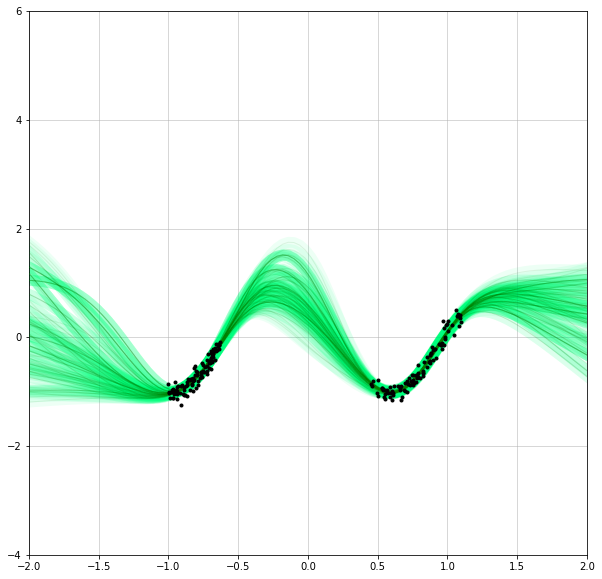

In [230]:
fig=setup.makePlot(S,device)